In [1]:
%load_ext autoreload
%autoreload 2

import autorootcwd # Do not delete - adds the root of the project to the path

### Data loading & processing

In [2]:
import torch

from ml.data import load_data

device = "cuda" if torch.cuda.is_available() else "cpu"
batch_size = 128

data, selected = load_data("data_processing/output")

print(data)

data_cut = data[selected]
data_rest = data[~selected]

print(data_cut)
print(data_rest)

# For reproducibility
torch.manual_seed(0)

trn_cut, val, tst, (i_trn_cut, i_val, i_tst) = data_cut.split(0.8, return_indices=True)
trn_uncut = trn_cut + data_rest

print(trn_cut)
print(trn_uncut)
print(val)

signal_idx = val.y_names.index("ttH")
print(f"{signal_idx=}")

Loading data: 100%|██████████| 12/12 [00:01<00:00, 10.97it/s]


Data(n_samples=8874951, n_features=127, n_classes=17)
Data(n_samples=32768, n_features=127, n_classes=17)
Data(n_samples=8842183, n_features=127, n_classes=17)
Data(n_samples=26214, n_features=127, n_classes=17)
Data(n_samples=8868397, n_features=127, n_classes=17)
Data(n_samples=6554, n_features=127, n_classes=17)
signal_idx=0


### Training

##### Find the optimal LR for a given model

Stopping early because the loss has exploded                                   
Searching for the optimal LR:  86%|████████▌ | 86/100 [00:00<00:00, 586.77it/s]


Found lr=0.03126 with min_loss=1.65037


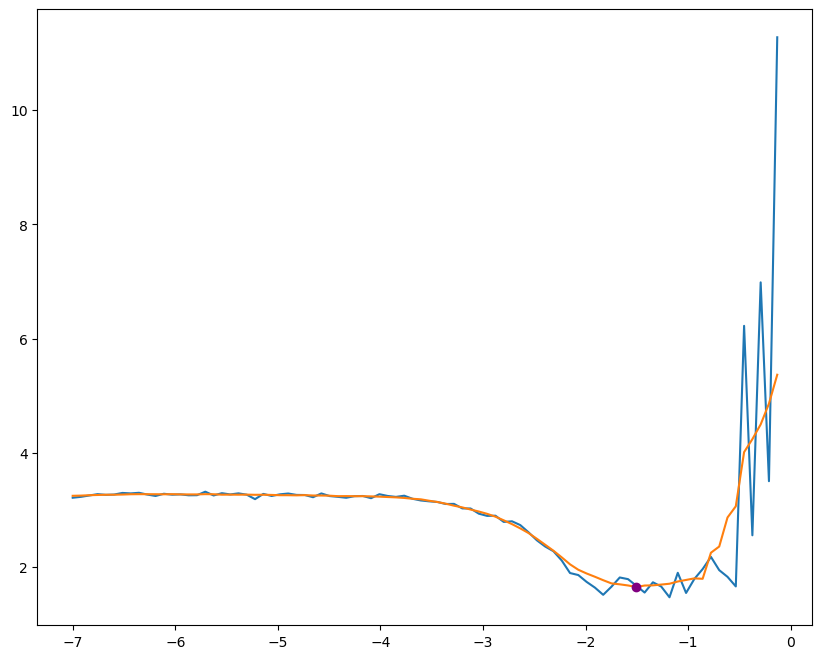

In [46]:
import torch
import matplotlib.pyplot as plt

from ml.nn import Transformer, ResNet
from ml.training import find_lr


def get_model():
    torch.manual_seed(0)  # For reproducibility

    # model = Transformer(
    #     trn_cut.n_features_continuous,
    #     trn_cut.categorical_sizes,
    #     trn_cut.n_classes,
    #     n_embed=32,
    #     n_blocks=2,
    #     n_heads=4,
    #     dropout=0,
    # )

    model = ResNet(
        trn_uncut.n_features_continuous,
        trn_uncut.categorical_sizes,
        trn_uncut.n_classes,
        n_embed=16,
        n_blocks=1,
        dropout=0.0,
        use_embedding=False,
    ).to(device)

    # model = torch.compile(model)
    model = model.to(device)

    return model

model = get_model()

def Optim(params, lr):
    return torch.optim.Adam(params, lr=lr)

device="cpu"

lr, min_loss = find_lr(model,
                       trn_cut,
                       Optim,
                       batch_size=batch_size,
                       lr_divisions=100,
                       ax=plt.subplots(figsize=(10, 8))[1],
                       device=device, 
                       half=None)
print(f"Found lr={lr:.5f} with min_loss={min_loss:.5f}")

##### Train the model

In [49]:
from ml.training import train
from ml.evaluation import evaluate

# Create the model, optimizer, and scheduler
model = get_model()
optim = Optim(model.parameters(), lr=lr)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optim, patience=500, factor=0.1, threshold=0.01, verbose=True, min_lr=1e-7)

# Train. Obtain the checkpoints of the best and the last models
model.train()

trn = trn_cut

# Get a single batch from trn
# batch_size = 128
# batch = next(iter(trn.batches(batch_size)))
# trn = batch

val = val

F = (trn.n_samples + val.n_samples) /  val.n_samples  # This is different - to have "same" normalization factor

half = torch.float16
half = None

stats, best, last = train(
    model,
    optim,
    trn,
    evaluate.using(model, trn, val, "ttH", device=device, use_tqdm=False, F=F, batch_size=batch_size, half=half),
    epochs=10,
    validate_freq=1,
    restart=True,
    use_tqdm=False,
    device=device,
    batch_size=batch_size,
    scheduler=scheduler,
    half=half,
    # wandb_run="transformer-debugging",
    );


Initial evaluation:
Epoch 0: val/loss=3.2774, trn/loss=3.2729, val/acc=2.53%, val/acc/bin=63.77%, val/f1=0.03%, AUC (mean)=0.547, AUC (ttH)=0.527, significance=2.08 (60.20% of max possible (3.46)) @ threshold=0.01

+    1s: Epoch 1: val/loss=1.3347, trn/loss=1.3122, val/acc=38.65%, val/acc/bin=55.85%, val/f1=51.61%, AUC (mean)=0.663, AUC (ttH)=0.620, significance=2.14 (61.75% of max possible (3.46)) @ threshold=0.23
+    1s: Epoch 2: val/loss=1.3054, trn/loss=1.2841, val/acc=40.37%, val/acc/bin=50.11%, val/f1=52.99%, AUC (mean)=0.718, AUC (ttH)=0.627, significance=2.13 (61.66% of max possible (3.46)) @ threshold=0.28
+    1s: Epoch 3: val/loss=1.2842, trn/loss=1.2558, val/acc=38.06%, val/acc/bin=54.83%, val/f1=51.26%, AUC (mean)=0.726, AUC (ttH)=0.642, significance=2.15 (62.07% of max possible (3.46)) @ threshold=0.18
+    1s: Epoch 4: val/loss=1.2743, trn/loss=1.2442, val/acc=39.70%, val/acc/bin=51.26%, val/f1=55.44%, AUC (mean)=0.749, AUC (ttH)=0.635, significance=2.15 (62.06% of max

Epoch 10: val/loss=1.2308, trn/loss=1.2008, val/acc=42.26%, val/acc/bin=51.48%, val/f1=54.26%, AUC (mean)=0.764, AUC (ttH)=0.643, significance=2.16 (62.54% of max possible (3.46)) @ threshold=0.29
Epoch -1: val/loss=1.2308, trn/loss=1.2008, val/acc=42.26%, val/acc/bin=51.48%, val/f1=54.26%, AUC (mean)=0.764, AUC (ttH)=0.643, significance=2.16 (62.54% of max possible (3.46)) @ threshold=0.29
Epoch 5: val/loss=1.2669, trn/loss=1.2355, val/acc=41.41%, val/acc/bin=53.20%, val/f1=57.20%, AUC (mean)=0.750, AUC (ttH)=0.649, significance=2.15 (62.27% of max possible (3.46)) @ threshold=0.25
Epoch -1: val/loss=1.2669, trn/loss=1.2355, val/acc=41.41%, val/acc/bin=53.20%, val/f1=57.20%, AUC (mean)=0.750, AUC (ttH)=0.649, significance=2.15 (62.27% of max possible (3.46)) @ threshold=0.25


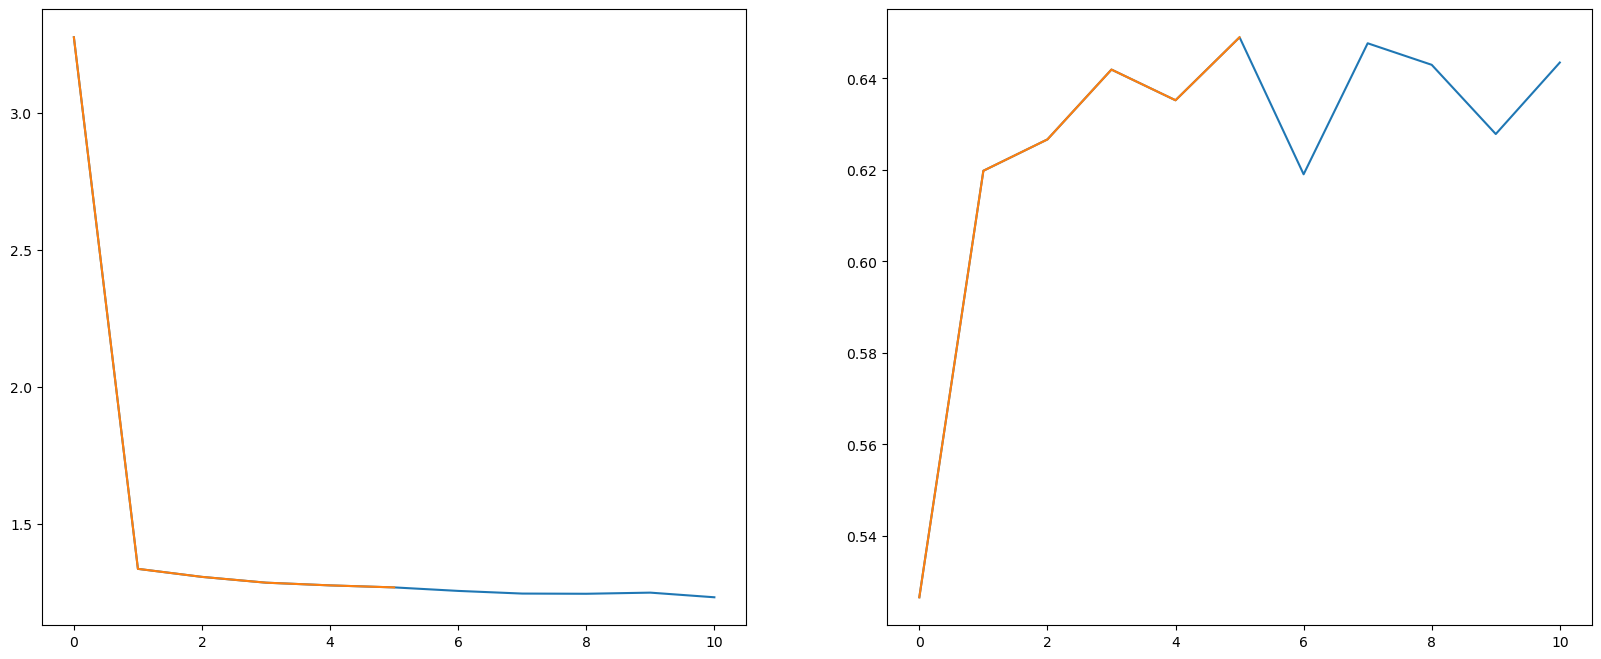

In [50]:
from ml.training import load_checkpoint

fig, axs = plt.subplots(1, 2, figsize=(20, 8))

model.eval()

path = f"./ml/checkpoints/{model.name}-last"
stats_last = load_checkpoint(path, model)

print(stats_last[-1])
print(evaluate.using(model, trn, val, "ttH", device=device, use_tqdm=False, F=F, batch_size=batch_size, half=half)(-1))

axs[0].plot([s.metrics["val/loss"] for s in stats_last], label="val/loss")
axs[1].plot([s.metrics["val/auc_w/ttH"] for s in stats_last], label="auc_w/ttH")

path = f"./ml/checkpoints/{model.name}-best"
stats_best = load_checkpoint(path, model)

print(stats_best[-1])
print(evaluate.using(model, trn, val, "ttH", device=device, use_tqdm=False, F=F, batch_size=batch_size, half=half)(-1))


axs[0].plot([s.metrics["val/loss"] for s in stats_best], label="val/loss")
axs[1].plot([s.metrics["val/auc_w/ttH"] for s in stats_best], label="auc_w/ttH")

# Loading the trained model

In [4]:
# Loading the model from wandb
from ml.evaluation import evaluate
from ml.download_model import download_model
from ml.nn import ResNet, Transformer

# model_name = "resnets/resnet-8"
model_name = "transformers/transformer-5-100-data-5000-batch-20-drop"
# model_name = "transformers/transformer-2"

path = download_model(model_name)

cls = Transformer if "transformer" in model_name else ResNet
model = cls.from_saved(path)
model.to(device)

# # sd = torch.load("ml/artifacts/transformer-2/model-2.pt")
# model.load_state_dict({k.replace("_orig_mod.", ""): v for k, v in sd.items()})

# Evaluate the model

model.eval()

trn = trn_cut
F = (trn.n_samples + val.n_samples) /  val.n_samples  # This is different - to have "same" normalization factor
half = torch.float16
half = None

loaded = torch.load(path)
print(loaded["stats_best"][-1])

with torch.no_grad():
    evaluation = evaluate.using(model, trn, val, "ttH", device=device, use_tqdm=False, F=F, batch_size=batch_size, half=half)(loaded["stats_best"][-1].epoch)
    print(evaluation)


------------------------------------ Config ------------------------------------

seed: 0
use_wandb: True
project_name: mtcp
data_path: data_processing/output
use_binary: False
use_weights: False
use_embedding: False
use_nan_w: False
dropout: 0.2
n_embed_categorical: 8
cuts: discard
trn_split: 0.8
fraction: 1
compile: True
use_half: True
repeat: 1
batch_size: 5000
epochs: 100
tags: ['experiment']
evaluations: ['significance', 'roc', 'confusion_matrix', 'feature_importance']
model: transformer
n_blocks: 5
n_embed: 256
n_heads: 4
run_name: transformer-5-100-data-5000-batch-20-drop
device: cuda
cuda_device: 0
dtype: torch.float16
checkpoints_dir: ml/checkpoints

--------------------------------------------------------------------------------

Found run transformer-5-100-data-5000-batch-20-drop (vushycay)
Epoch 69: val/loss=0.8074, trn/loss=0.4546, val/acc=63.73%, val/acc/bin=73.30%, val/f1=64.07%, AUC (mean)=0.919, AUC (ttH)=0.823, significance=2.52 (72.85% of max possible (3.46)) @ thre

# Evaluations

### ROC curves

/home.stud/yazykvla/.local/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/home.stud/yazykvla/.local/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/home.stud/yazykvla/.local/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/home.stud/yazykvla/.local/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/home.stud/yazykvla/.local/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningle

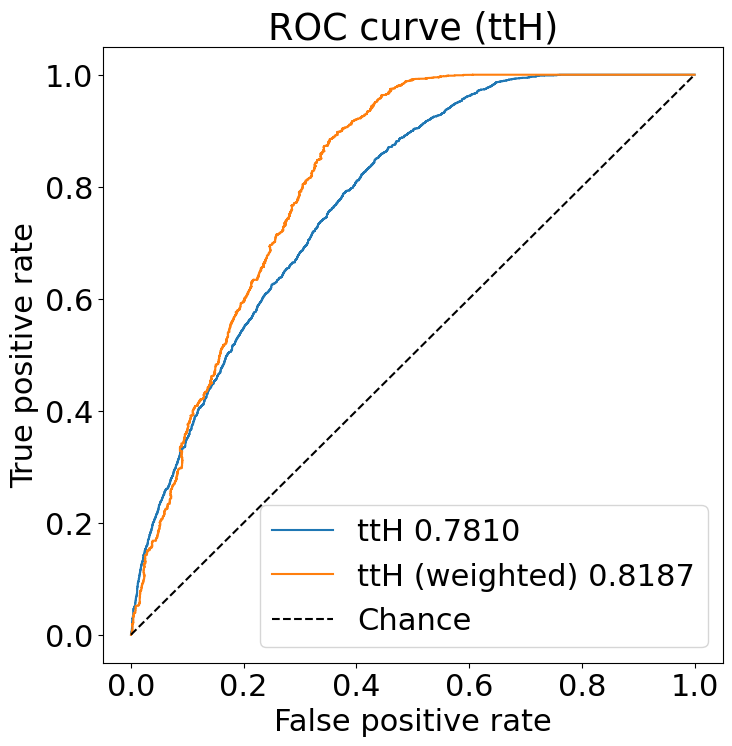

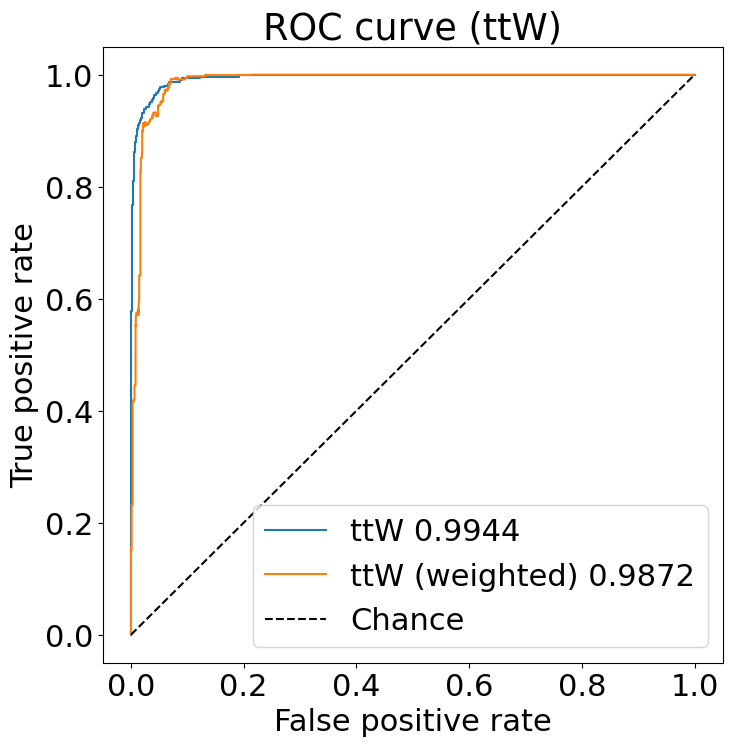

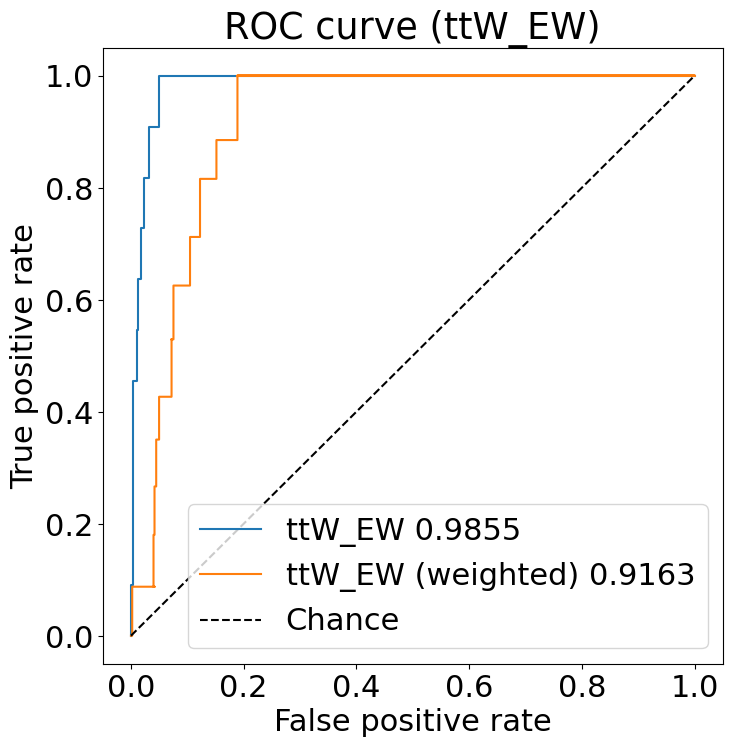

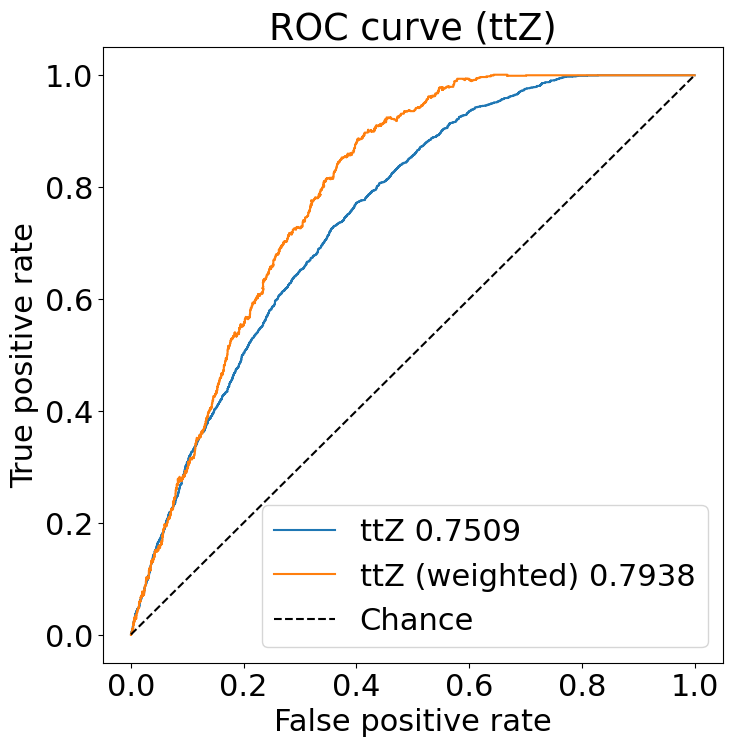

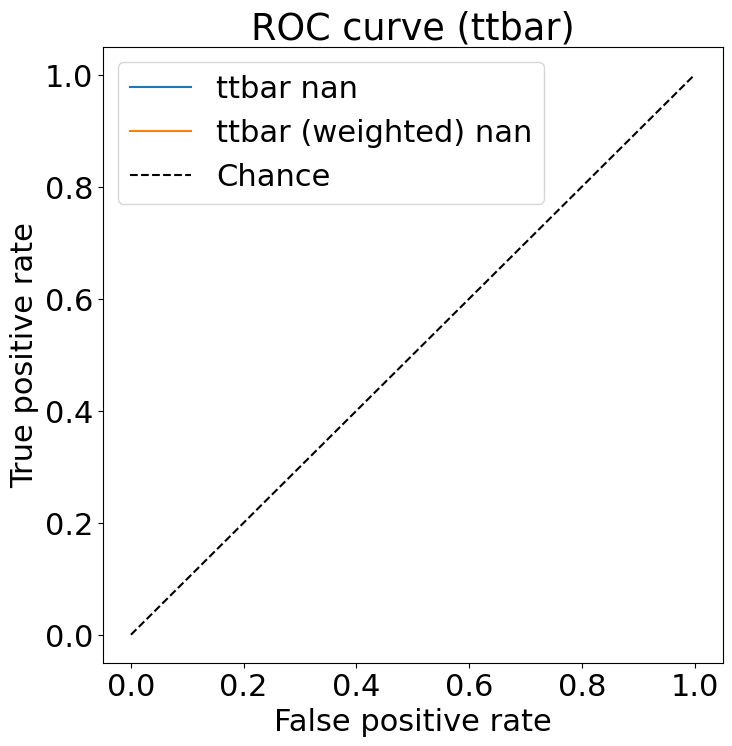

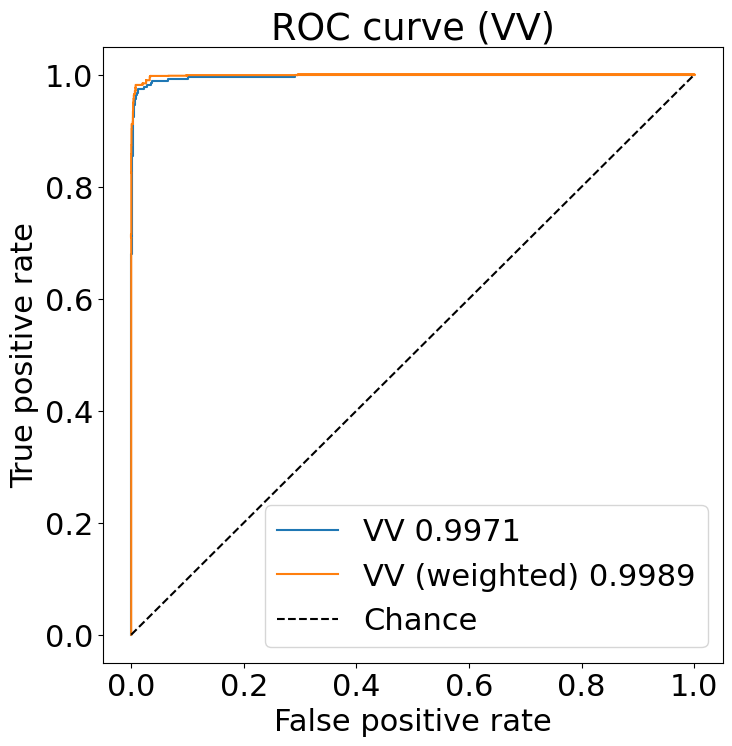

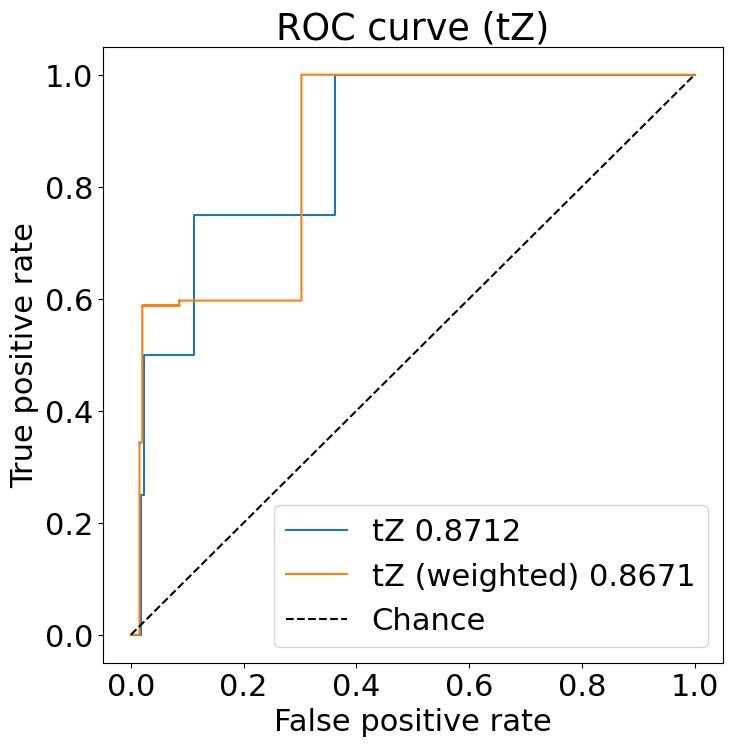

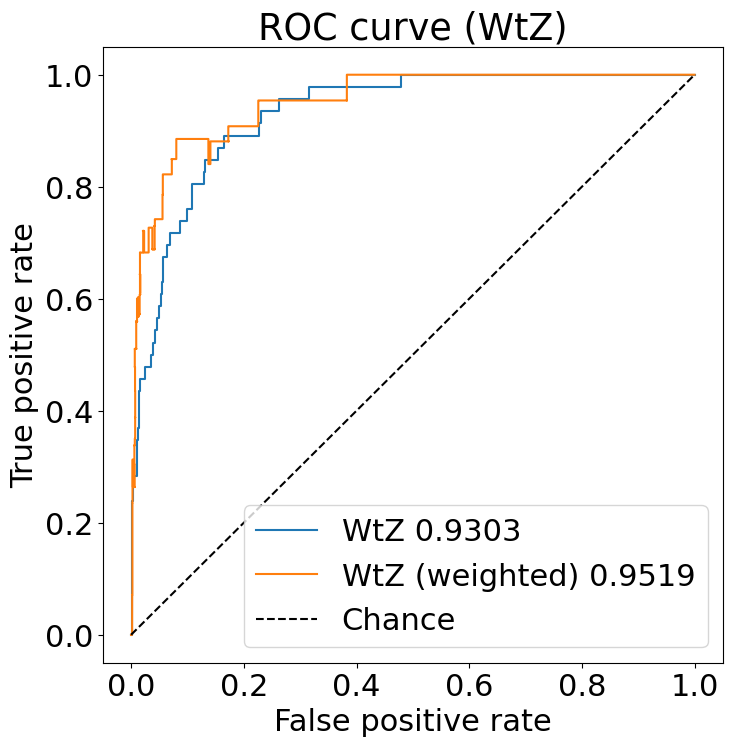

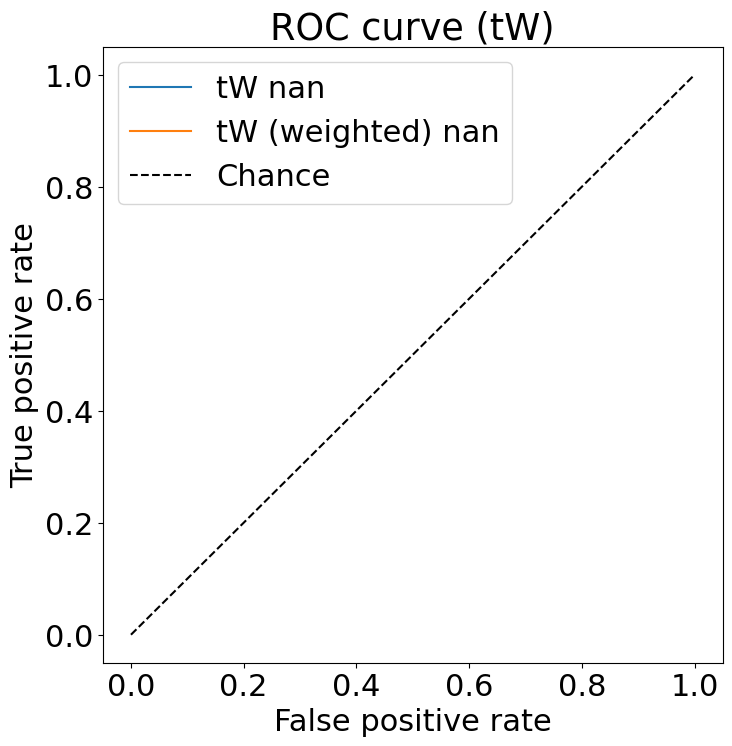

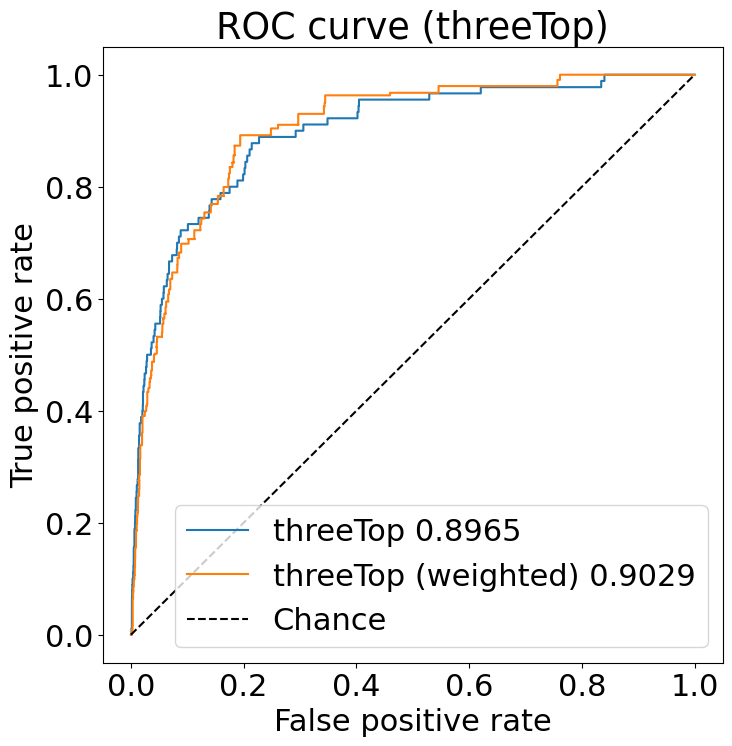

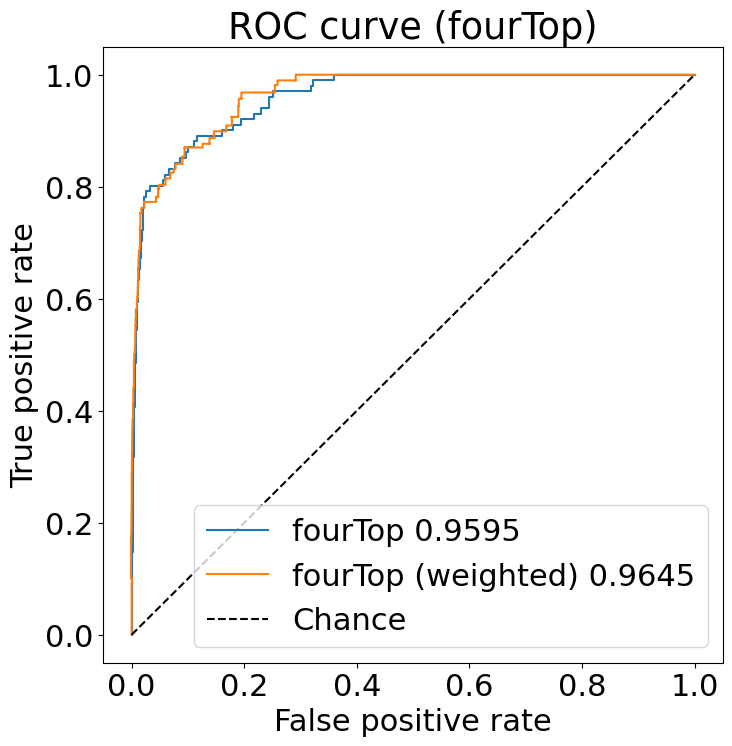

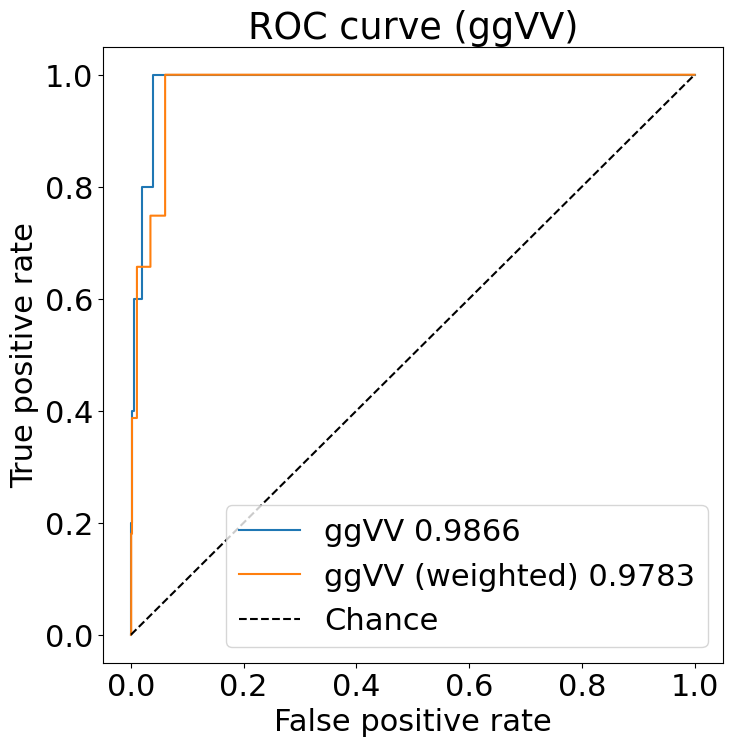

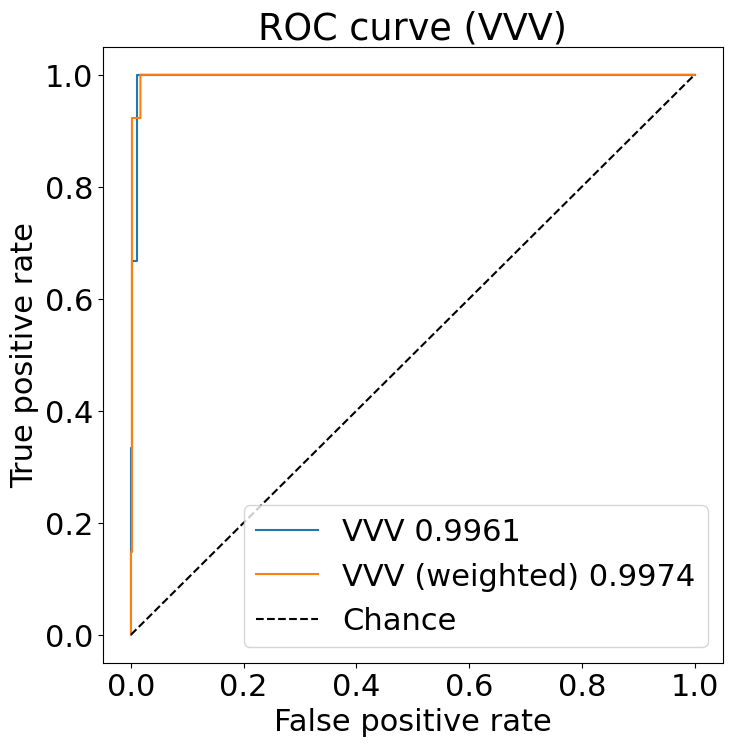

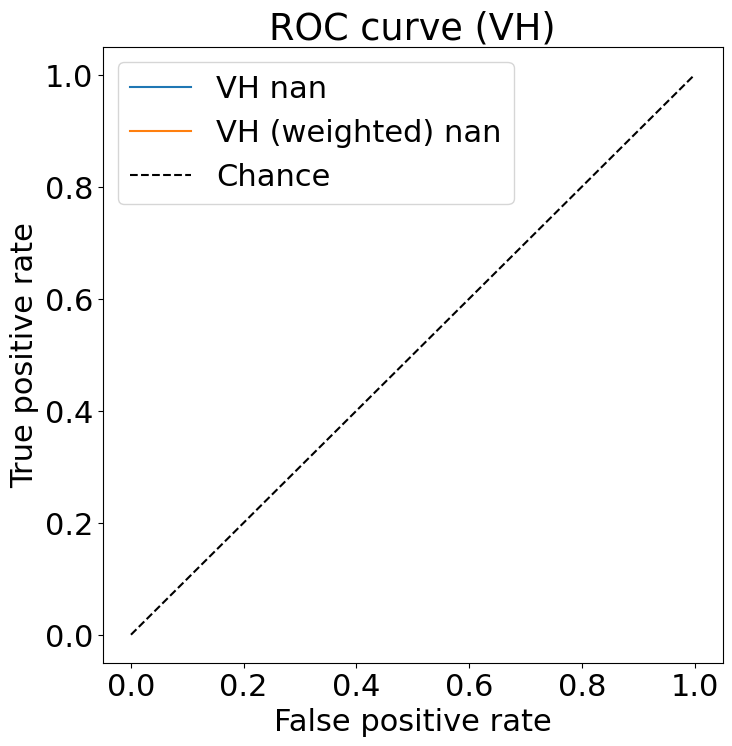

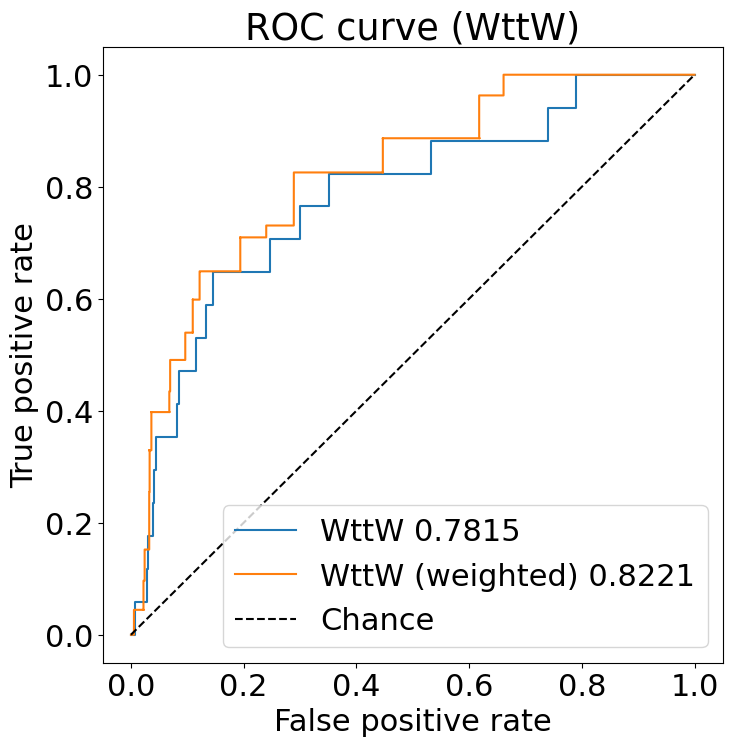

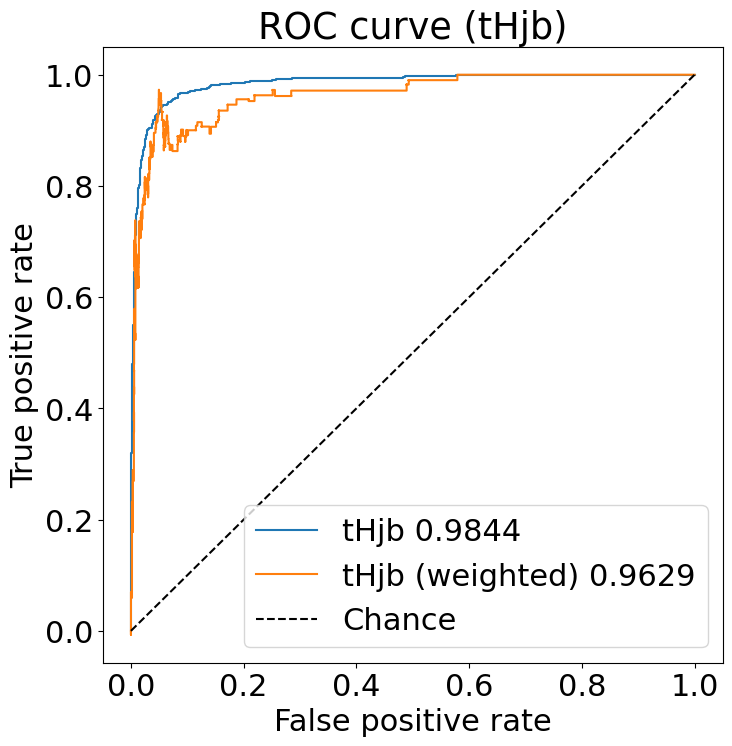

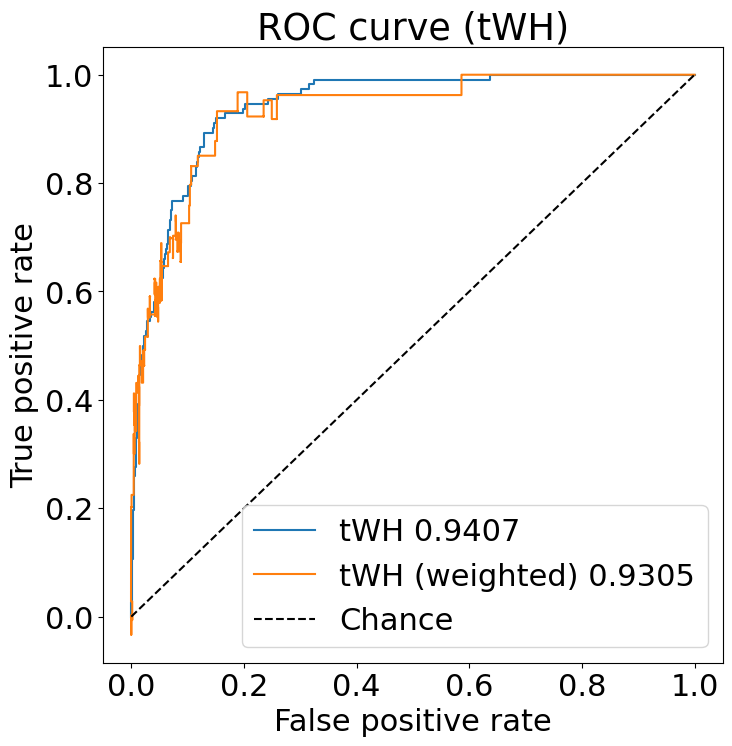

In [6]:
from sklearn.metrics import roc_curve, roc_auc_score
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams.update({'font.size': 22})

# Get probs on the validation set
with torch.no_grad():
    probs = torch.cat([model(batch.to(device)) for batch in val.batches(batch_size=batch_size, shuffle=False)]).softmax(dim=1).cpu()

for i in range(val.n_classes):
    fpr, tpr, _ = roc_curve(val.y, probs[:, i], pos_label=i)
    auc = np.trapz(tpr, fpr)

    fprw, tprw, _ = roc_curve(val.y, probs[:, i], pos_label=i, sample_weight=val.w.cpu())
    aucw = np.trapz(tprw, fprw)

    fig, ax = plt.subplots(figsize=(8, 8))

    ax.plot(fpr, tpr, label=f"{val.y_names[i]} {auc:.4f}")
    ax.plot(fprw, tprw, label=f"{val.y_names[i]} (weighted) {aucw:.4f}")
    ax.plot([0, 1], [0, 1], linestyle="--", c="k", label="Chance")
    ax.set_ylabel("True positive rate")
    ax.set_xlabel("False positive rate")
    ax.set_title(f"ROC curve ({val.y_names[i]})")
    ax.legend()

    # print(f"{auc_custom=:.4f} {auc_sklearn=:.4f} n_points={len(fpr)}")

    # Now trully custom auc - calculate fpr tpr yourself
    # signal_probs = probs[:, 0]
    # print(len(np.unique(signal_probs)))

/home.stud/yazykvla/.local/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


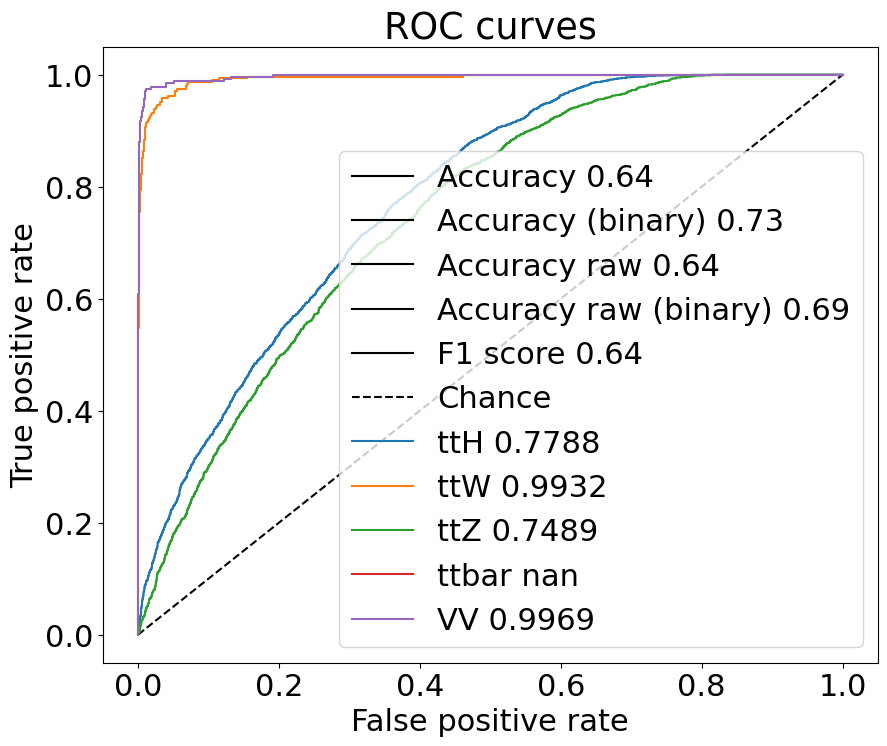

In [7]:
from ml.evaluation import evaluate

# Get probs on the validation set
with torch.no_grad():
    probs = torch.cat([model(batch.to(device)) for batch in val.batches(batch_size=batch_size, shuffle=False)]).softmax(dim=1).cpu()

fig, ax = plt.subplots(figsize=(10, 8))

# Dummy plot to include accuracy in the legend
ax.plot([], [], label=f"Accuracy {evaluation.metrics['val/acc/multi']:.2f}", c="k")
ax.plot([], [], label=f"Accuracy (binary) {evaluation.metrics['val/acc/bin']:.2f}", c="k")

ax.plot([], [], label=f"Accuracy raw {evaluation.metrics['val/acc/multi_raw']:.2f}", c="k")
ax.plot([], [], label=f"Accuracy raw (binary) {evaluation.metrics['val/acc/bin_raw']:.2f}", c="k")

# Dummy plot for the f1 score
ax.plot([], [], label=f"F1 score {evaluation.metrics['val/f1']:.2f}", c="k")

ax.plot([0, 1], [0, 1], linestyle="--", c="k", label="Chance")

classes = ["ttH", "ttW", "ttZ", "ttbar", "VV"]
for c in classes:
    i = val.y_names.index(c)
    fpr, tpr, _ = roc_curve(val.y, probs[:, i], pos_label=i)
    auc = np.trapz(tpr, fpr)

    ax.plot(fpr, tpr, label=f"{val.y_names[i]} {auc:.4f}")

ax.set_ylabel("True positive rate")
ax.set_xlabel("False positive rate")
ax.set_title(f"ROC curves")
ax.legend()

    # print(f"{auc_custom=:.4f} {auc_sklearn=:.4f} n_points={len(fpr)}")

    # Now trully custom auc - calculate fpr tpr yourself
    # signal_probs = probs[:, 0]
    # print(len(np.unique(signal_probs)))

### AUROC

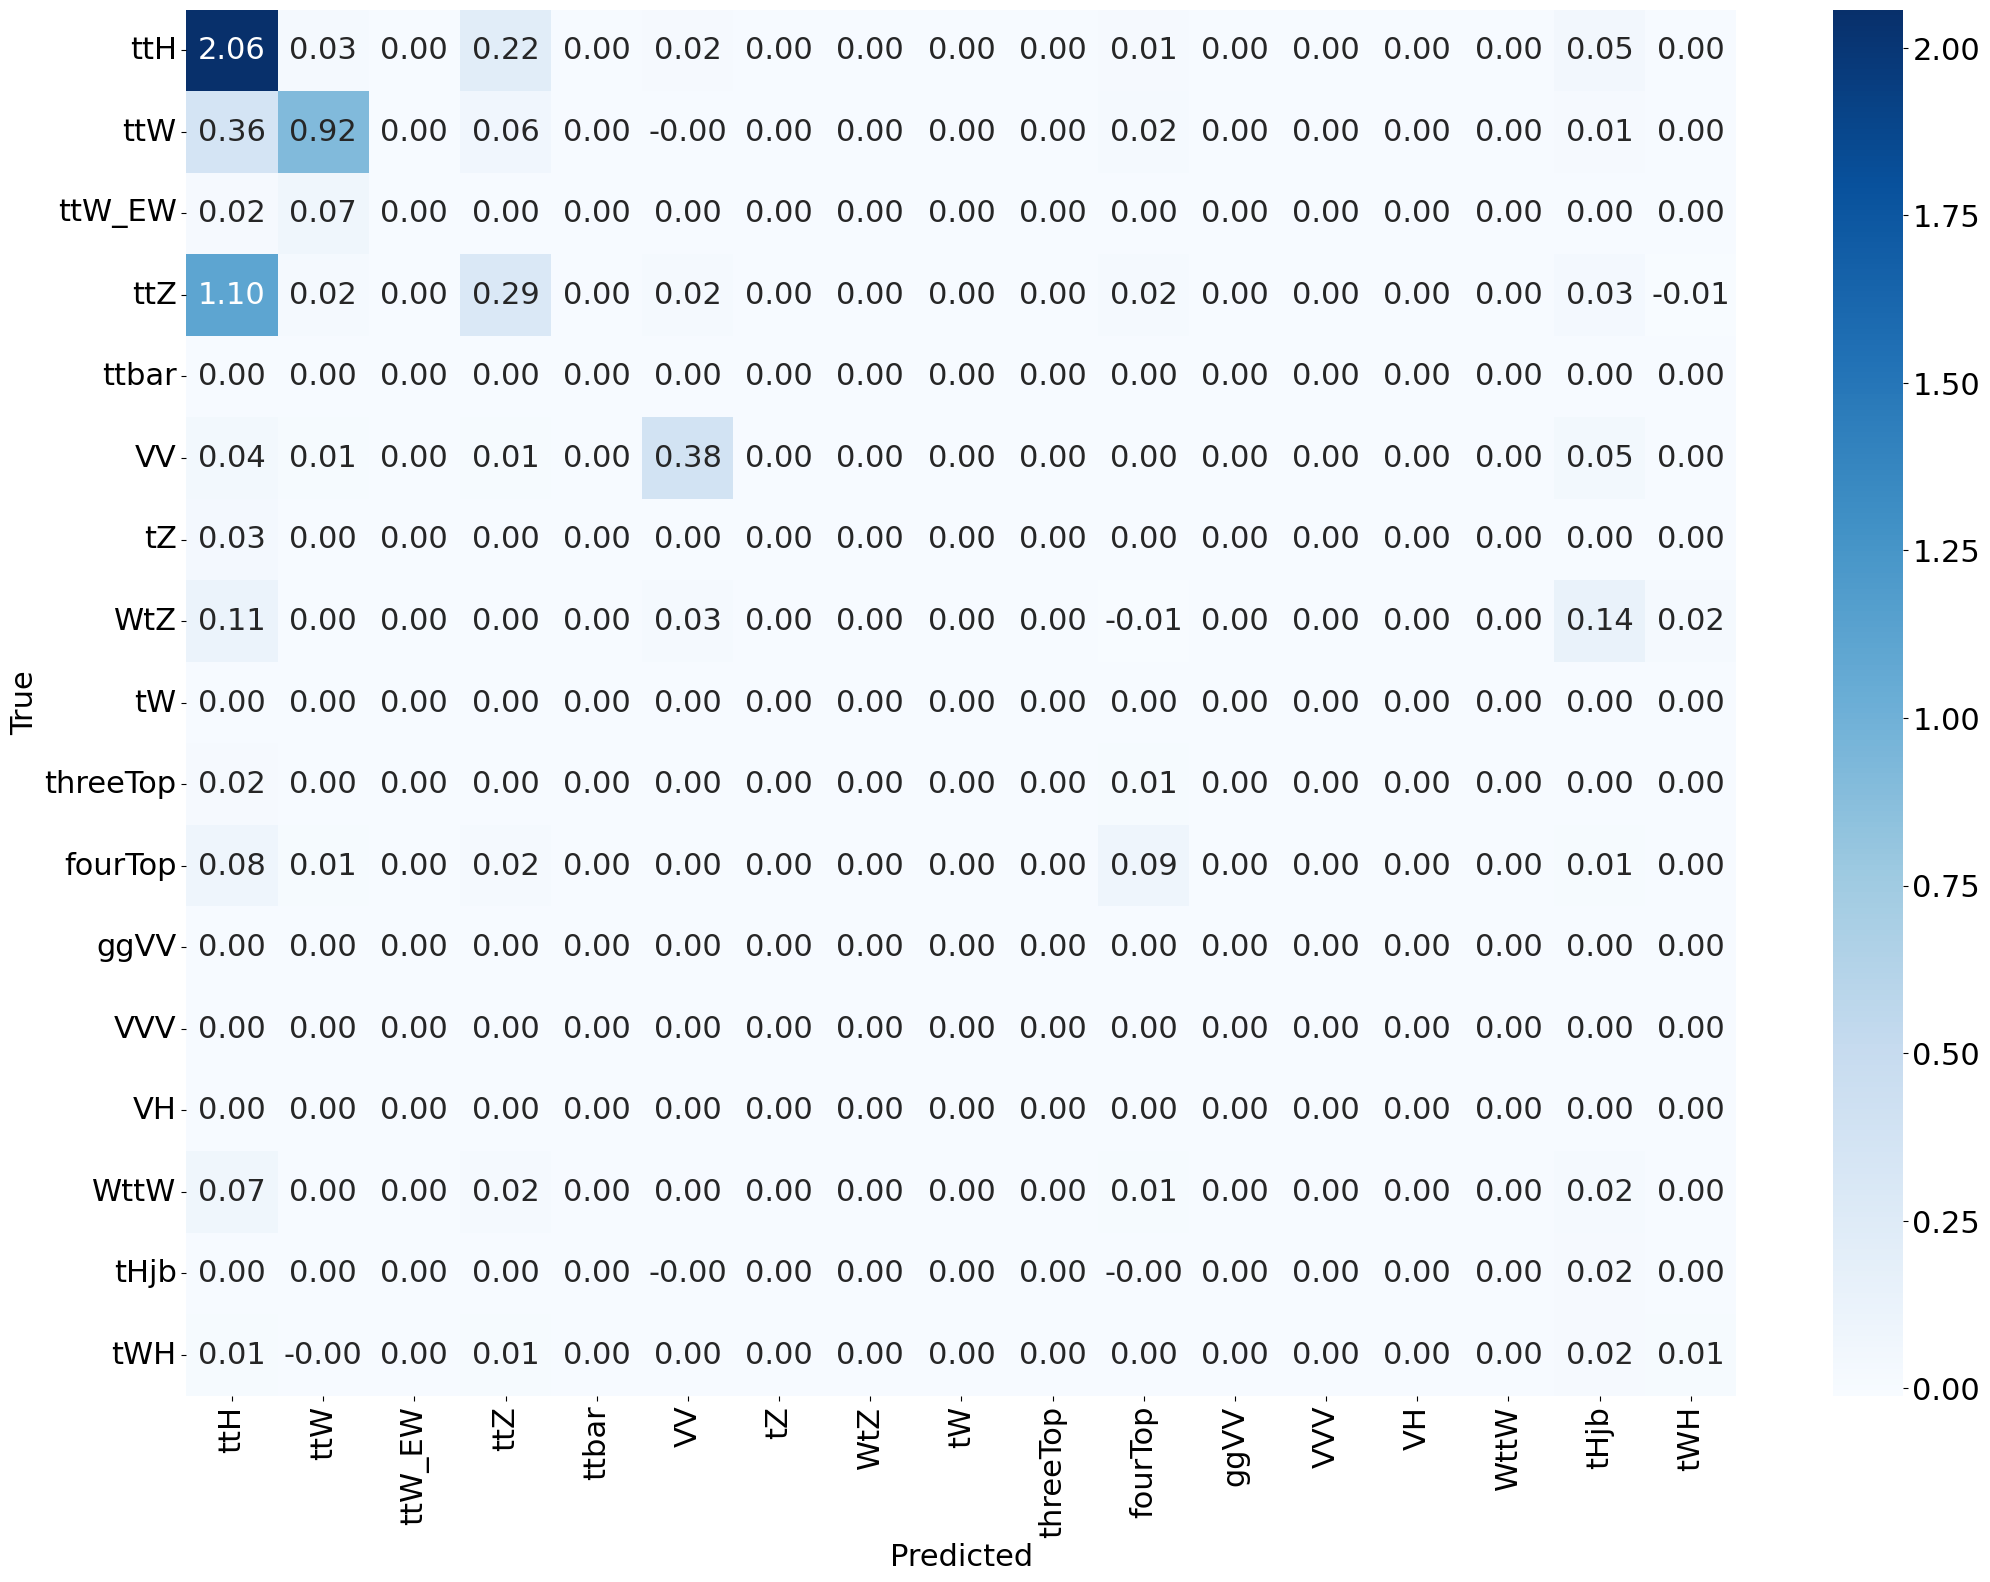

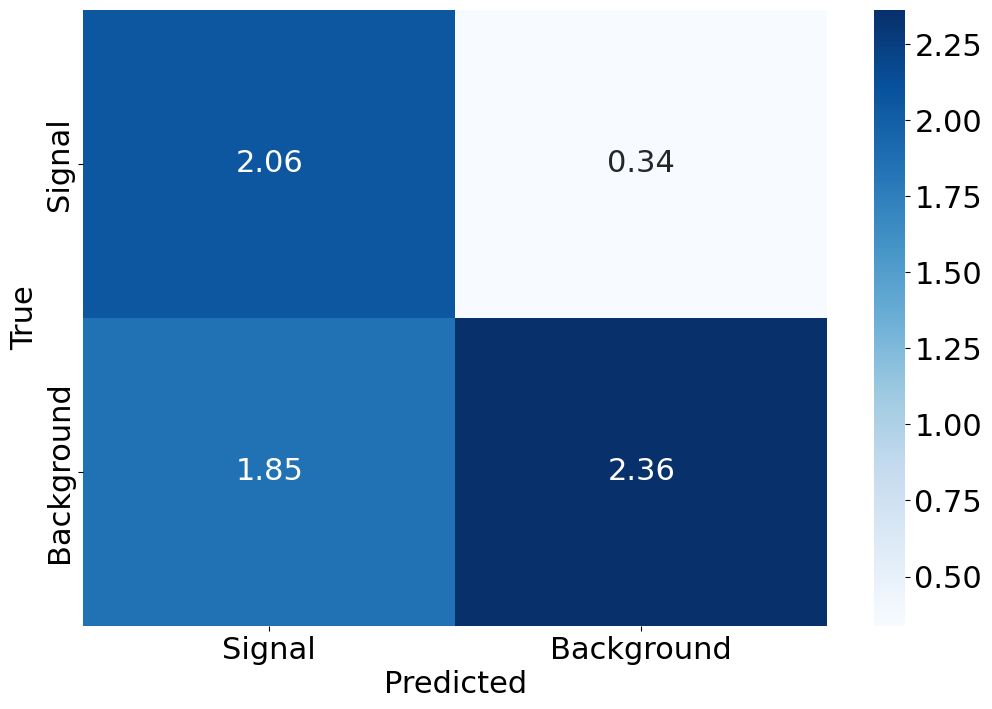

In [17]:
from ml.evaluation import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

y_pred = torch.cat([model.predict(batch.to(device)) for batch in val.batches(batch_size=batch_size, shuffle=False)]).cpu()

# Plot CM for all the classes
cm = confusion_matrix(y_pred, val.y, val.w, n_classes=val.n_classes)

_, ax1 = plt.subplots(figsize=(25, 18))
sns.heatmap(cm.cpu(), annot=True, cmap="Blues", cbar=True,  ax=ax1, xticklabels=val.y_names, yticklabels=val.y_names, fmt=".2f")
ax1.set_xlabel("Predicted")
ax1.set_ylabel("True")

# Now plot CM for just the signal class
cm = confusion_matrix(y_pred, val.y, val.w, signal=val.y_names.index("ttH"))

_, ax2 = plt.subplots(figsize=(12, 8))
sns.heatmap(cm.cpu(), annot=True, cmap="Blues", cbar=True,  ax=ax2, xticklabels=["Signal", "Background"], yticklabels=["Signal", "Background"], fmt=".2f")
ax2.set_xlabel("Predicted")
ax2.set_ylabel("True");

### Significance


How it's calculated:

- We get class probabilities from our model.

- We then take a look at the probability for our signal event (ttH).
  - **If the probability is greater than the threshold, we simply classify the event as signal.**
  - **Otherwise we pick the highest probability among all the other classes** (but this just means it's classified as background).

- Then we create a weighted confusion matrix.

- We calculate the scaling/nomralization factor $F = \frac{|\mathcal{T}_{trn}|}{|\mathcal{T}_{val}|}$.

- We calculate signal $s$ as the TPR, and background $b$ as the FPR.

- We calculate the significance as $S = \frac{s}{\sqrt{s+b}}\sqrt{F}$.

Maximum significance: 2.5194311141967773 at threshold 0.17017017304897308


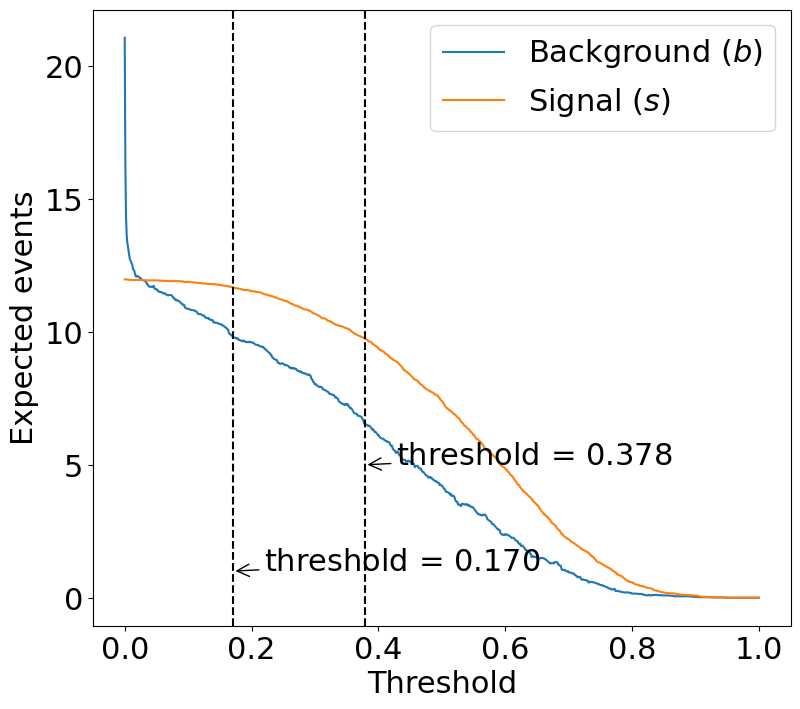

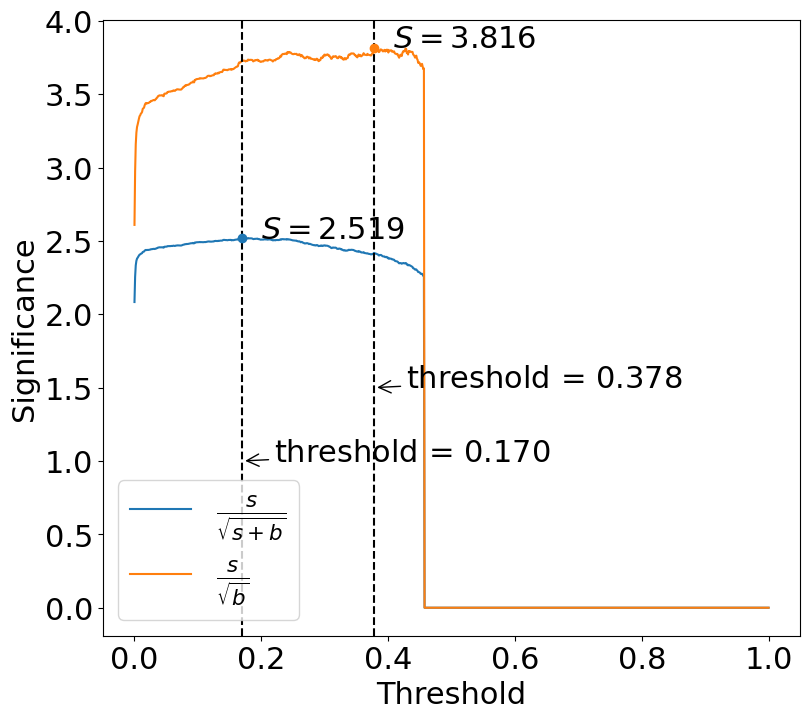

In [17]:
import matplotlib.pyplot as plt
from ml.evaluation import find_significance_threshold


torch.set_printoptions(precision=3, sci_mode=False)

with torch.no_grad():
    logits = torch.cat([model(batch.to(device)) for batch in val.batches(batch_size=batch_size, shuffle=False)]).cpu()

# Probabilities
probs = torch.softmax(logits, dim=1)

# Now let's check all the thresholds where the significance is the highest
F = (trn_cut.n_samples + val.n_samples) / val.n_samples
threshold, significance, stats = find_significance_threshold(
    probs,
    val.y,
    val.w,
    val.y_names.index("ttH"),
    F,
    n_significance_thresholds=1000,
    return_stats=True,
    min_background=1,
)

threshold_simple, significance_simple, stats_simple = find_significance_threshold(
    probs,
    val.y,
    val.w,
    val.y_names.index("ttH"),
    F,
    n_significance_thresholds=1000,
    return_stats=True,
    include_signal=False,
    min_background=1,
)

print(f"Maximum significance: {significance} at threshold {threshold}")

# Let's also calculate the best possible significance we can get on the validation set. This happens if we classify all events correctly
# S_max = trn.max_significance()

# Plot two figures one below another
# First sub-figure:
fig, ax1 = plt.subplots(1, 1, figsize=(9, 8))

# Plot the (expected) number of signal and background events
thresholds, significances, signals, backgrounds = zip(*[[si.cpu() for si in s] for s in stats])
thresholds_simple, significances_simple, *_ = zip(*[[si.cpu() for si in s] for s in stats_simple])

ax1.plot(thresholds, backgrounds, label=f"Background ($b$)")
ax1.plot(thresholds, signals, label=f"Signal ($s$)")
ax1.set_xlabel("Threshold")
ax1.set_ylabel("Expected events")

threshold = threshold.cpu()
significance = significance.cpu()
threshold_simple = threshold_simple.cpu()
significance_simple = significance_simple.cpu()

# Plot the dashed vertical line at the best threshold and annotate it
ax1.axvline(threshold, linestyle="--", color="black")
ax1.annotate(f"threshold = ${threshold:.3f}$", (threshold, 1), (threshold + 0.05, 1), arrowprops=dict(arrowstyle="->"))

ax1.axvline(threshold_simple, linestyle="--", color="black")
ax1.annotate(f"threshold = ${threshold_simple:.3f}$", (threshold_simple, 5), (threshold_simple + 0.05, 5), arrowprops=dict(arrowstyle="->"))

# Plot points at the number of signal and background events at the best threshold and annotate them
ax1.legend()

# Second subfigure
fig, ax2 = plt.subplots(1, 1, figsize=(9, 8))

# Plot the significance
ax2.plot(thresholds, significances, label=r"$\frac{s}{\sqrt{s+b}}$")
ax2.plot(thresholds_simple, significances_simple, label=r"$\frac{s}{\sqrt{b}}$")

# Plot the dashed vertical line at the best threshold and annotate it
ax2.axvline(threshold, linestyle="--", color="black")
ax2.annotate(f"threshold = ${threshold:.3f}$", (threshold, 1), (threshold + 0.05, 1), arrowprops=dict(arrowstyle="->"))

ax2.axvline(threshold_simple, linestyle="--", color="black")
ax2.annotate(f"threshold = ${threshold_simple:.3f}$", (threshold_simple, 1.5), (threshold_simple + 0.05, 1.5), arrowprops=dict(arrowstyle="->"))

# Plot points at the significance at the best threshold and annotate it
ax2.scatter(threshold, significance, color="C0", zorder=10)
ax2.annotate(f"$S={significance:.3f}$", (threshold, significance), (threshold + 0.03, significance - 0.0))

ax2.scatter(threshold_simple, significance_simple, color="C1", zorder=10)
ax2.annotate(f"$S={significance_simple:.3f}$", (threshold_simple, significance_simple), (threshold_simple + 0.03, significance_simple - 0.0))

ax2.legend(loc="lower left")
ax2.set_xlabel("Threshold")
ax2.set_ylabel("Significance");

### Confusion matrix

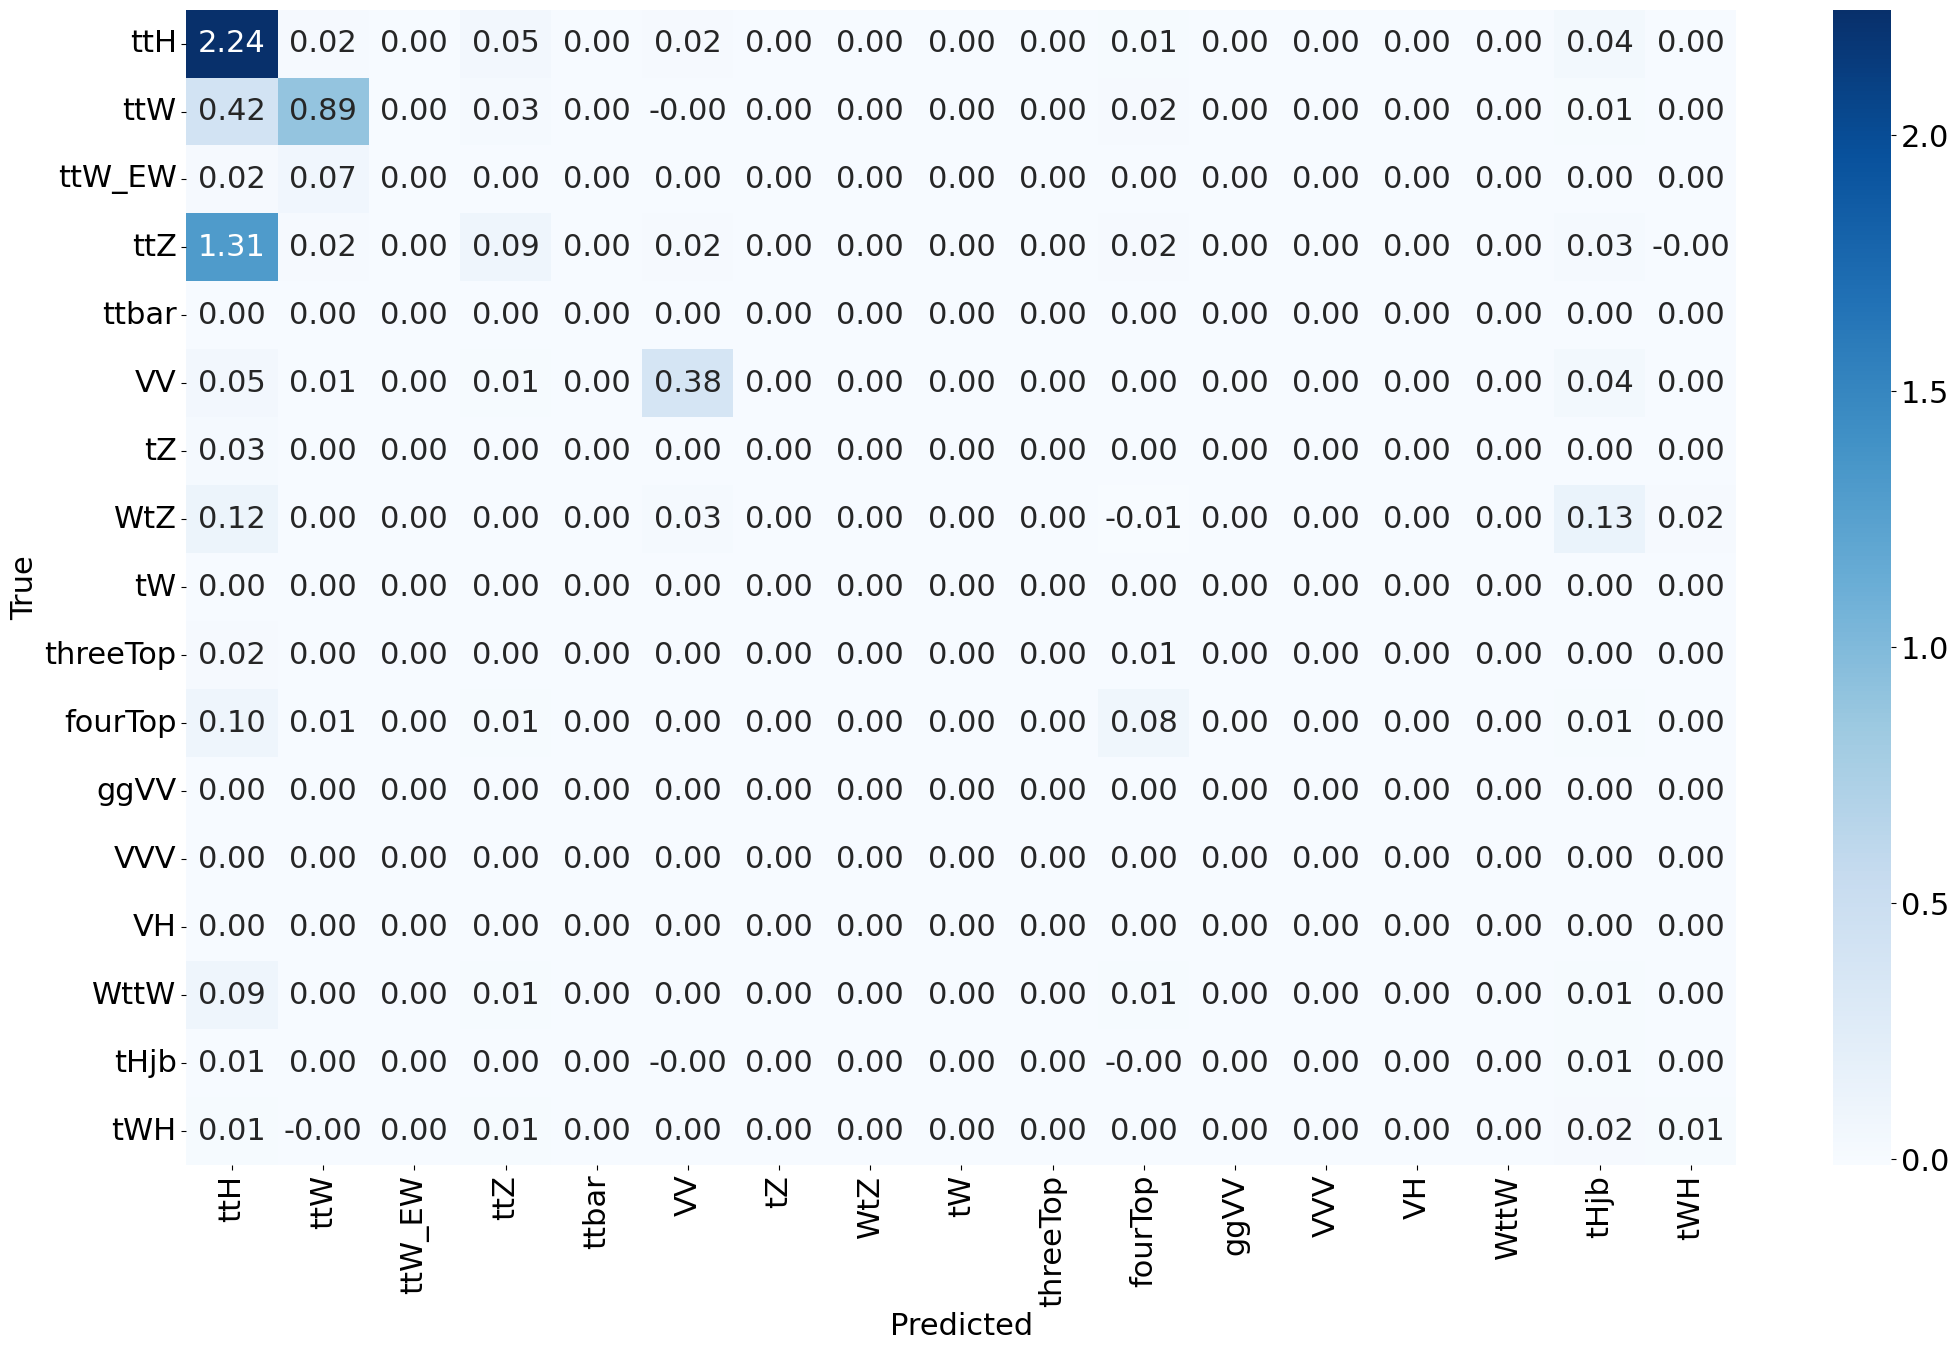

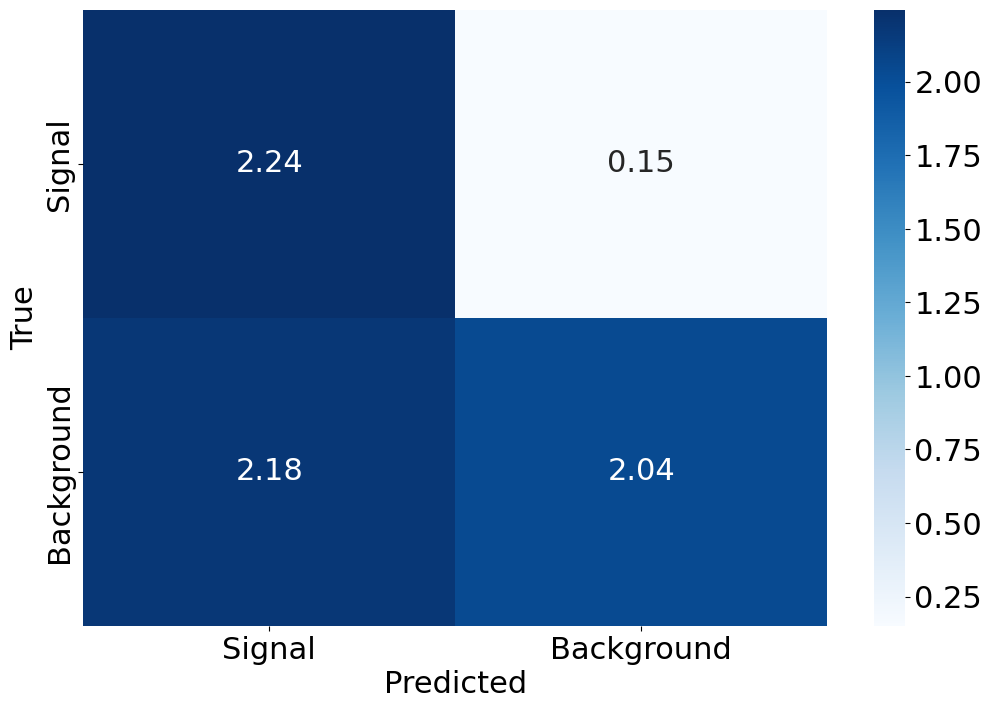

In [19]:
from ml.evaluation import confusion_matrix
import seaborn as sns


signal_idx = val.y_names.index("ttH")
y_pred = torch.cat([
    model.predict(batch.to(device), threshold=threshold, signal_idx=signal_idx) 
    for batch in val.batches(batch_size=batch_size, shuffle=False)
]).cpu()

# Plot CM for all the classes
cm = confusion_matrix(y_pred, val.y, val.w, n_classes=val.n_classes)

_, ax1 = plt.subplots(figsize=(25, 15))
sns.heatmap(cm.cpu(), annot=True, cmap="Blues", cbar=True,  ax=ax1, xticklabels=val.y_names, yticklabels=val.y_names, fmt=".2f")
ax1.set_xlabel("Predicted")
ax1.set_ylabel("True")

# Now plot CM for just the signal class
cm = confusion_matrix(y_pred, val.y, val.w, signal=val.y_names.index("ttH"))

_, ax2 = plt.subplots(figsize=(12, 8))
sns.heatmap(cm.cpu(), annot=True, cmap="Blues", cbar=True,  ax=ax2, xticklabels=["Signal", "Background"], yticklabels=["Signal", "Background"], fmt=".2f")
ax2.set_xlabel("Predicted")
ax2.set_ylabel("True");

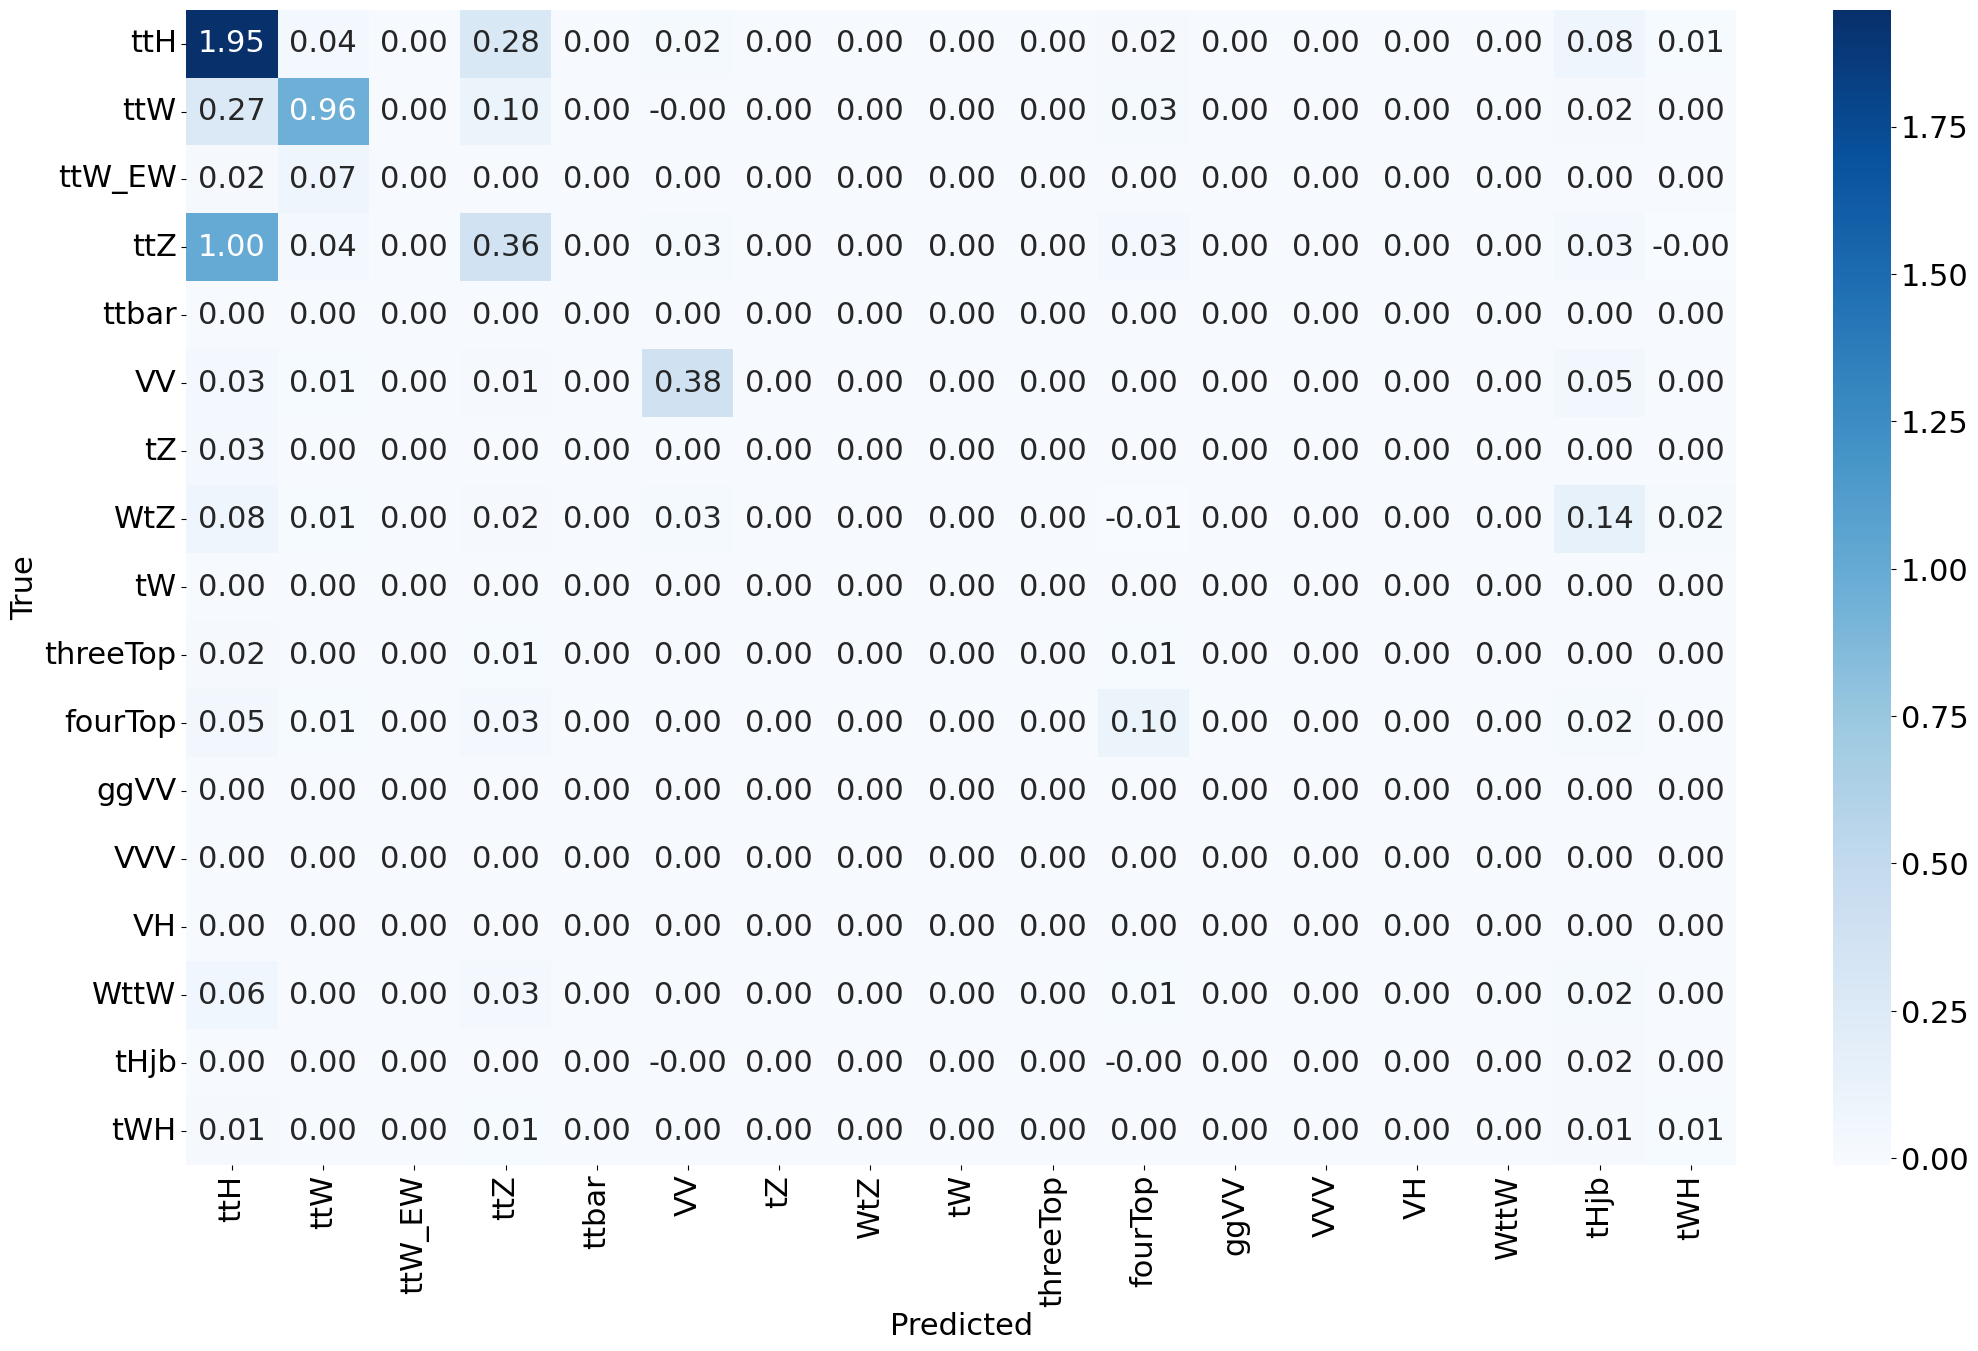

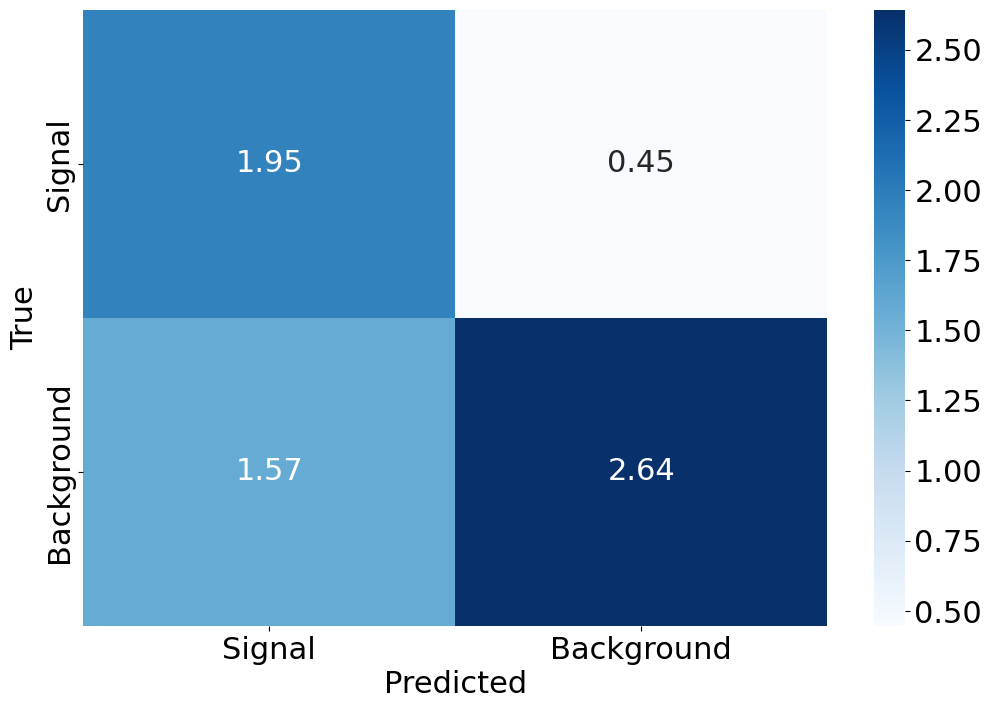

In [21]:
from ml.evaluation import confusion_matrix
import seaborn as sns


signal_idx = val.y_names.index("ttH")
y_pred = torch.cat([
    model.predict(batch.to(device), threshold=threshold_simple, signal_idx=signal_idx) 
    for batch in val.batches(batch_size=batch_size, shuffle=False)
]).cpu()

# Plot CM for all the classes
cm = confusion_matrix(y_pred, val.y, val.w, n_classes=val.n_classes)

_, ax1 = plt.subplots(figsize=(25, 15))
sns.heatmap(cm.cpu(), annot=True, cmap="Blues", cbar=True,  ax=ax1, xticklabels=val.y_names, yticklabels=val.y_names, fmt=".2f")
ax1.set_xlabel("Predicted")
ax1.set_ylabel("True")

# Now plot CM for just the signal class
cm = confusion_matrix(y_pred, val.y, val.w, signal=val.y_names.index("ttH"))

_, ax2 = plt.subplots(figsize=(12, 8))
sns.heatmap(cm.cpu(), annot=True, cmap="Blues", cbar=True,  ax=ax2, xticklabels=["Signal", "Background"], yticklabels=["Signal", "Background"], fmt=".2f")
ax2.set_xlabel("Predicted")
ax2.set_ylabel("True");

### Feature importance

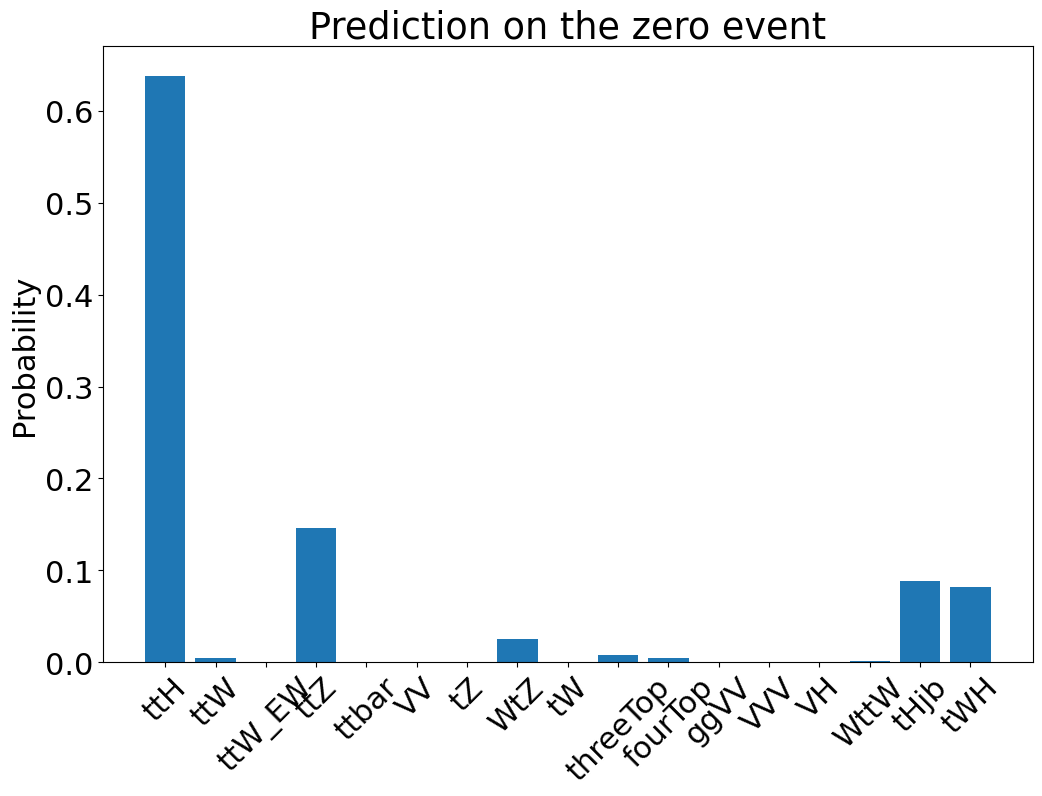

In [22]:
from ml.data import Data

# First, let's see what is the prediciton on the empty event
# There is a problem that a zero tensor is not actually an empty event, but let's ignore that for now
# (by the way, Severin also uses just zero tensors for the empty event)
sample = val[[0]]
baseline = Data.zeros(val.n_features_continuous, val.categorical_sizes, **val.metadata)

model.eval()
with torch.no_grad():
    probs = model(baseline.to(device)).softmax(dim=1).view(-1) # Get the probabilities

fig, ax = plt.subplots(figsize=(12, 8))
ax.bar(torch.arange(val.n_classes), probs.cpu())
ax.set_xticks(torch.arange(val.n_classes), val.y_names, rotation=45)
ax.set_ylabel("Probability")
ax.set_title("Prediction on the zero event");

Calculating integrated gradients:   0%|          | 0/10 [00:00<?, ?it/s]

Calculating integrated gradients: 100%|██████████| 10/10 [00:05<00:00,  1.82it/s]


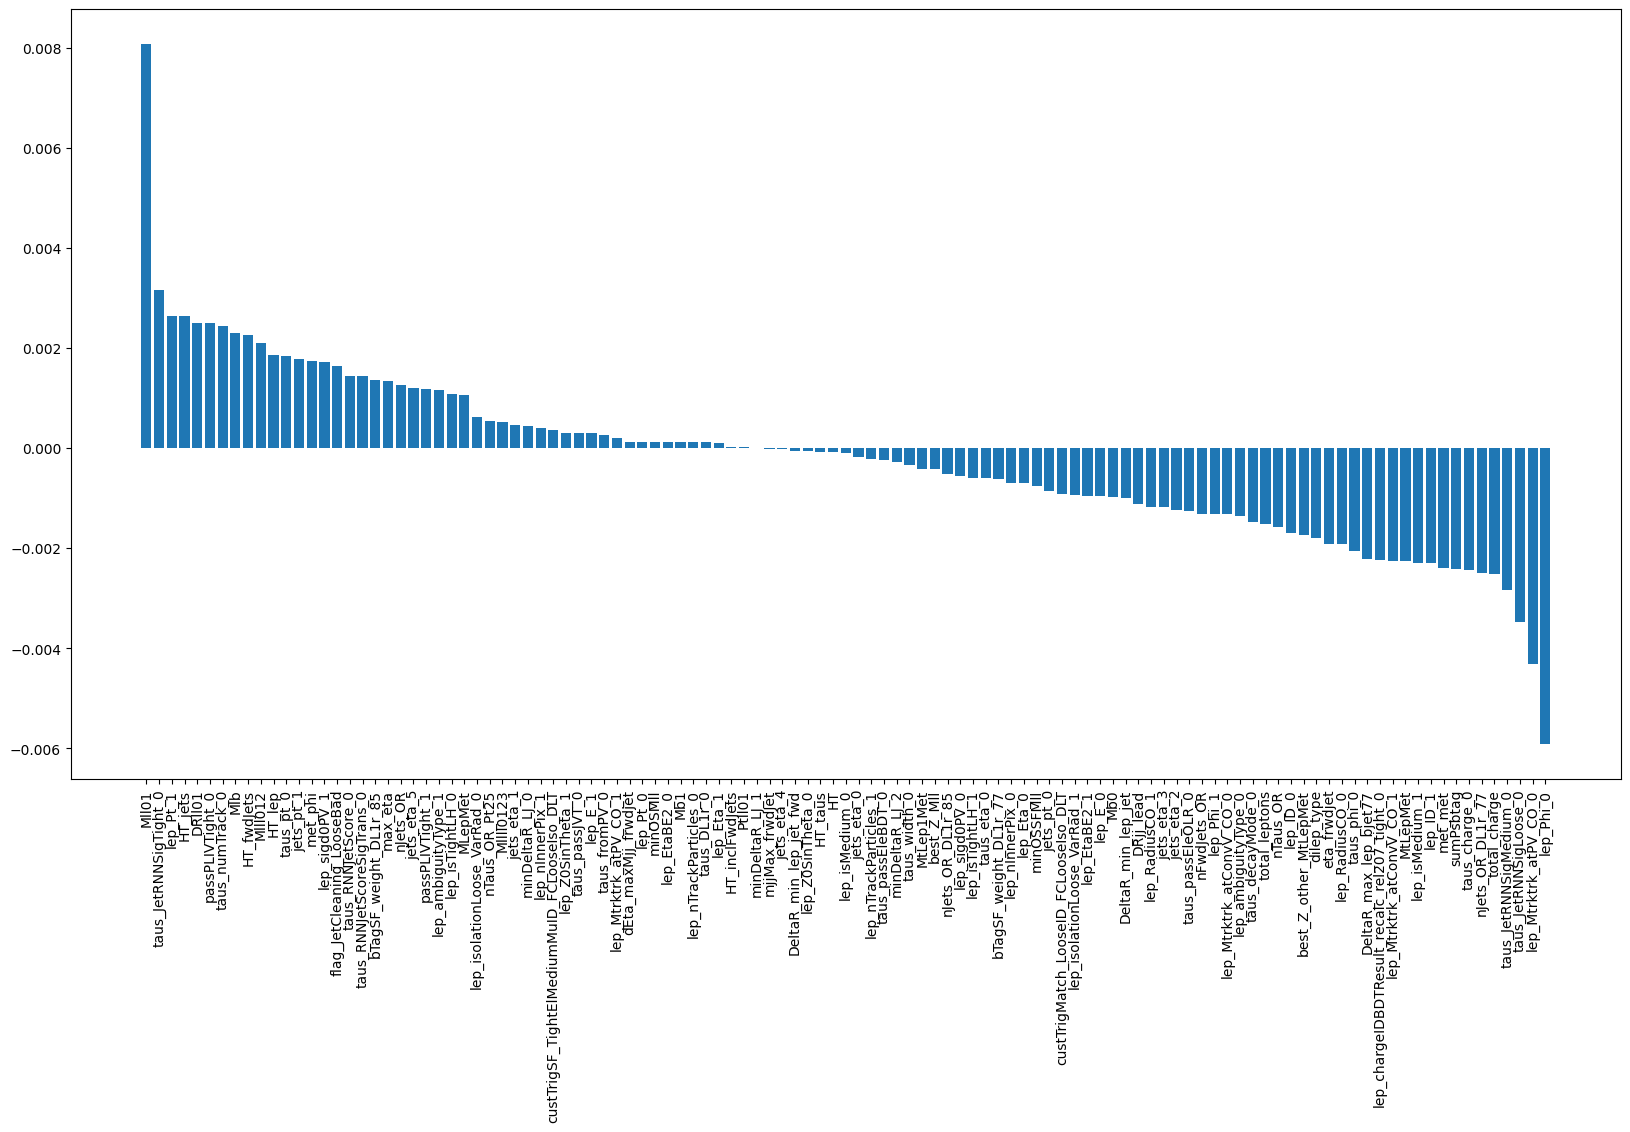

In [6]:
import matplotlib.pyplot as plt
from ml.evaluation import feature_importance

plt.rcParams.update({'font.size': 10})

torch.manual_seed(0)

ig = feature_importance(model, val, val.y_names.index("ttH"), val.x_names, device=device, num_examples=10, plot="horizontal")

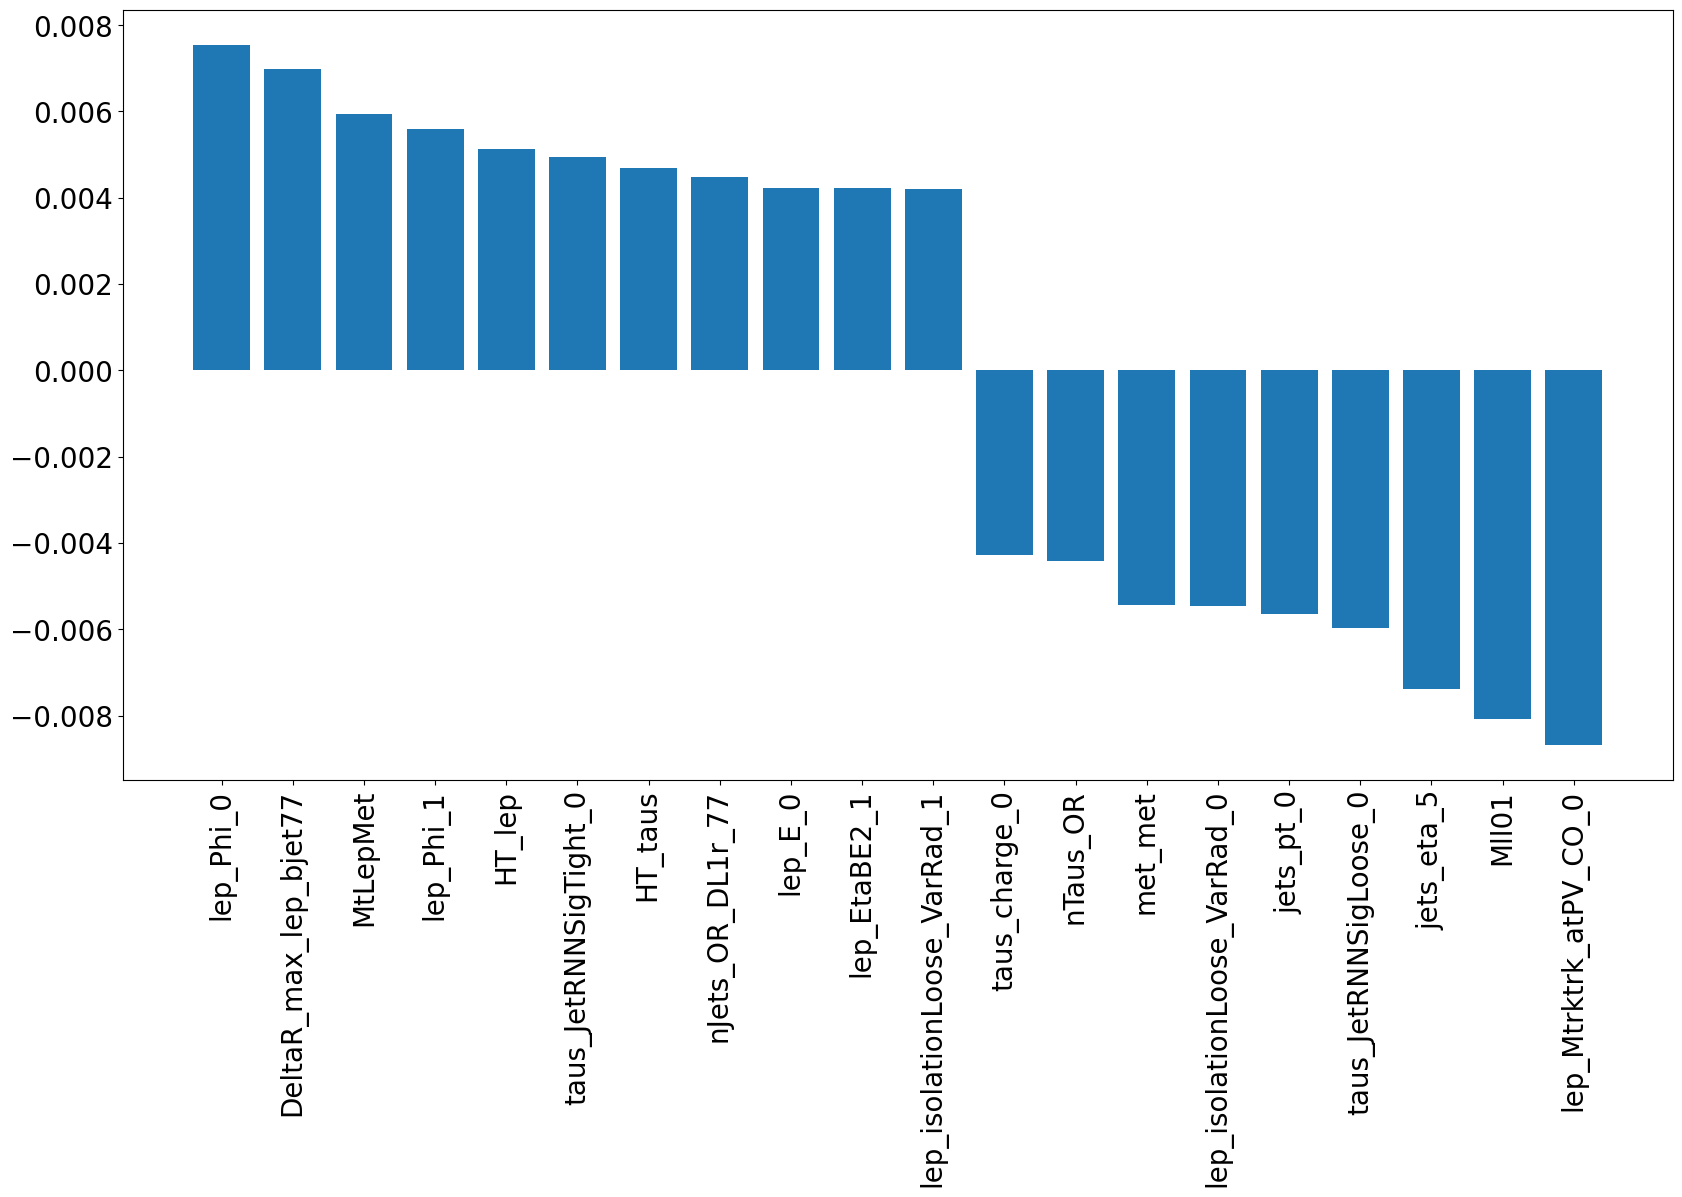

In [24]:
plt.rcParams.update({'font.size': 20})

n_features = 20
# Now we can plot the integrated gradients
# For now let's drop the object feature (our simple model doesn't use it anyway)
plt.figure(figsize=(20, 10))
ig_sorted, indices = torch.sort(ig.abs(), descending=False)
ig_sorted = ig[indices][-n_features:] # Use this if you also want to see positive/negative
indices = indices[-n_features:]

# Now also sort in ascending order
ig_sorted, ii = torch.sort(ig_sorted, descending=True)
indices = indices[ii]

# ig_sorted = ig_sorted[-n_features:]
plt.bar(torch.arange(len(ig_sorted)), ig_sorted.cpu())
plt.xticks(torch.arange(len(ig_sorted)), [val.x_names[i] for i in indices], rotation=90);

# Save probs to the root files

In [9]:
# Get probs on the validation set
with torch.no_grad():
    probs_val = torch.cat([model(batch.to(device)) for batch in val.batches(batch_size=batch_size, shuffle=False)]).softmax(dim=1)
    probs_all = torch.cat([model(batch.to(device)) for batch in data_cut.batches(batch_size=batch_size, shuffle=False)]).softmax(dim=1)

In [10]:
import os
import uproot

dirname = "ml/outputs/nn_output"
if not os.path.exists(dirname):
    os.makedirs(dirname)

# For each class, create a ROOT file with a single histogram
for y_true, class_name in enumerate(val.y_names):
    file_name = f"{dirname}/{class_name}.root"
    selected_events = val.y == y_true

    p_signal = probs_val[selected_events, signal_idx]
    # p_true = probs_val[selected_events, y_true]

    # selected_weights = val.w.to(device)[selected_events]

    # We need to select the events where the selected class matches the label

    # This histogram will contain the probability of event being of class `label`
    # This will be a simple list of size `num_samples`
    with uproot.recreate(file_name) as root_file:
        root_file["nominal"] = { 
            f"probs_{val.y_names[signal_idx]}": p_signal.cpu().numpy(),
            # "p_true": p_true.cpu().numpy(),
            # "weight": selected_weights.cpu().numpy()
        }

    with uproot.open(file_name) as root_file:
        print(class_name, root_file["nominal"][f"p_{val.y_names[signal_idx]}"].array())
        print(class_name, root_file["nominal"][f"p_true"].array())


ttH [0.802, 0.608, 0.367, 0.695, 0.644, ..., 0.494, 0.62, 0.364, 0.802, 0.188]
ttH [0.802, 0.608, 0.367, 0.695, 0.644, ..., 0.494, 0.62, 0.364, 0.802, 0.188]
ttW [1.51e-06, 0.489, 1.82e-05, 0.000589, ..., 2.67e-06, 0.00191, 0.0251, 0.729]
ttW [0.992, 0.00896, 0.916, 0.949, 0.756, ..., 0.986, 0.96, 0.984, 0.922, 0.0625]
ttW_EW [1.99e-05, 7.95e-06, 0.000286, 0.0149, ..., 3.03e-05, 3.42e-05, 0.000202]
ttW_EW [0.154, 0.0267, 0.0205, 0.0164, 0.0572, ..., 0.219, 0.117, 0.038, 0.124, 0.098]
ttZ [0.345, 0.614, 0.74, 0.69, 0.372, 0.364, ..., 0.387, 0.238, 0.353, 0.853, 0.431]
ttZ [0.636, 0.37, 0.255, 0.292, 0.404, ..., 0.584, 0.647, 0.633, 0.0476, 0.496]
ttbar []
ttbar []
VV [0.000112, 6.83e-07, 8.09e-06, 6.63e-07, ..., 0.00193, 0.04, 7.65e-06, 3.01e-08]
VV [0.976, 0.951, 0.914, 0.944, 0.969, 0.871, ..., 0.828, 0.904, 0.88, 0.973, 0.97]
tZ [0.356, 0.785, 0.658, 0.374]
tZ [0.00114, 0.000145, 0.0146, 0.0133]
WtZ [0.235, 0.155, 0.000108, 0.000174, 0.000314, ..., 0.000995, 0.359, 0.657, 0.138]
WtZ 

In [11]:
import numpy as np


total = 0
total_w = 0
for y_true, class_name in enumerate(val.y_names):
    file_name = f"{dirname}/{class_name}.root"
    with uproot.open(file_name) as root_file:
        w = root_file["nominal"]["weight"].array().to_numpy().sum()
        print(f"{class_name} {w:.2f}")
        total += w
        total_w += val.w[val.y == y_true].sum().item()


print(f"Total weight: {total:.2f}, should be {total_w:.2f}")

ttH 2.40
ttW 1.38
ttW_EW 0.09
ttZ 1.49
ttbar 0.00
VV 0.49
tZ 0.03
WtZ 0.29
tW 0.00
threeTop 0.03
fourTop 0.21
ggVV 0.00
VVV 0.00
VH 0.00
WttW 0.13
tHjb 0.02
tWH 0.05
Total weight: 6.61, should be 6.61


![probs](images/SR_probs.png)